# Segundo Proyecto: INGENIERÍA DE FEATURES, MODELOS AVANZADOS E INTERPRETACIÓN DE MODELOS

En esta entrega se trabajara con la misma problemática desarrollada en el primer proyecto, la cual es ayudar a los tasadores/as a valuar las propiedades de la inmobiliaria, para lo cual se propone desarrollar un modelo de Machine Learning que prediga el precio de venta de un inmueble a partir de ciertas características del mismo. El set de datos a utilizar es el mismo del primer proyecto: publicaciones de inmuebles destinados a venta en el sitio web de Properati.

En primer lugar, se realizará nuevamente una exploración de datos sobre el dataset aplicando tecnicas de preprocesamiento de datos, como imputación de valores faltantes, detección y eliminación de outliers, etc. Luego se aplicarán los mismos modelos de Machine Learning del Proyecto 1 (Regresión Lineal, Árbol de decisión y Vecinos más cercanos) y se compararán los resultados obtenidos.

Poseteriormente se incorporarán dos modelos avanzados de Machine Learning: un modelo Random Forest y un modelo de regresión lineal polinómica, y se compararán sus desempeños con los modelos del punto anterior.

Por último, se exponen las conclusiones a través del análisis de los resultados obtenidos por los distintos modelos.

# A. TRANSFORMACIÓN/ANÁLISIS EXPLORATORIO DE DATOS:

**Comentarios sobre el dataset** 
`
Capital Federal` refiere a la Ciudad de Buenos Aires. `Bs.As. G.B.A. Zona Norte`, `Bs.As. G.B.A. Zona Sur` y `Bs.As. G.B.A. Zona Oeste` son regiones que conforman el [Gran Buenos Aires](https://es.wikipedia.org/wiki/Gran_Buenos_Aires), un conjunto de ciudades que rodean a la Ciudad de Buenos Aires.

In [1]:
#Importamos las librerías a utilizar para analizar el dataset:
import pandas as pd
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [2]:
#En primer lugar, cargamos el dataset utilizando las funcionalidades de pandas:

data_propiedades = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv')

#Vemos cuantas filas y columnas tiene el dataset, es decir, su "forma":

print(data_propiedades.shape)

(146660, 19)


Esto nos dice que el dataset tiene 146.660 filas y 19 columnas.

In [3]:
#Observamos las primeras cinco instancias:

data_propiedades.head()

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,PH,Venta


In [4]:
#Renombramos las columnas l1, l2 y l3 por los niveles administrativos correspondientes de la ubicación de las propiedades (país, región o barrio)

data_propiedades = data_propiedades.rename(columns={'l1':'País', 'l2':'Región', 'l3':'Barrio'})

#Adicionalmente, chequeamos si el dataset contiene filas con datos duplicados:

filas_duplicadas = data_propiedades[data_propiedades.duplicated()]

#Chequeamos la cantidad de filas duplicadas:
print('Cantidad de filas duplicadas:', filas_duplicadas.shape[0])

Cantidad de filas duplicadas: 2358


Debido a que nuestro dataset contiene 2.358 filas duplicadas, esto puede distorsionar nuestro análisis, por lo que debemos eliminarlas.

In [5]:
#Eliminamos filas duplicadas:

data_propiedades = data_propiedades.drop_duplicates()

#Luego chequeamos la nueva forma de nuestro dataset:

data_propiedades.shape

(144302, 19)

## 1. Valores Faltantes

In [6]:
#Consultamos la cantidad de valores faltantes por columna:

print(data_propiedades.isnull().sum())

start_date             0
end_date               0
created_on             0
lat                 9572
lon                 9606
País                   0
Región                 0
Barrio                 0
rooms                  0
bedrooms               0
bathrooms           5924
surface_total      20261
surface_covered    21339
price                  0
currency               0
title                  0
description            0
property_type          0
operation_type         0
dtype: int64


Como podemos ver, las únicas columnas con valores faltantes son 'lat', 'lon', 'bathrooms', 'surface_total' y 'surface_covered', por lo que procederemos a aplicar distintas técnicas para imputar a los mismos.

En primer lugar, es razonable reemplazar los valores faltantes en la columna de superficie total por los valores contenidos en superficie cubierta, y viceversa:

In [7]:
data_propiedades.surface_covered.fillna(data_propiedades.surface_total, inplace=True)
data_propiedades.surface_total.fillna(data_propiedades.surface_covered, inplace=True)

Para los demás valores faltantes de las **variables de superficie**, considero que se podrían reemplazar por el promedio de superficie total y cubierta de acuerdo al tipo de propiedad, ya que puede variar mucho el tamaño promedio de una casa con el de un departamento y un depósito, por ejemplo. Para calcular esos estadísticos tomaremos una copia del dataset y depuraremos los outliers, de modo de obtener valores más aproximados, que luego incluiremos en el dataset original.

In [11]:
#Creamos una copia del dataset:

copia_propiedades = data_propiedades.copy()

copia_propiedades.shape

(144302, 19)

A continuación eliminaremos los outliers (o valores atípicos) del nuevo dataset aplicando dos criterios. Se efectuará un análisis más detallado de las distribuciones y valores atípicos de las variables (sobre el dataset original) más adelante en el presente trabajo:

 - Para las variables 'rooms', 'bedrooms' y 'bathrooms', el **criterio de las tres sigmas**, el cual establece umbrales mínimos y máximos de acuerdo a una función que parte del valor medio de los datos y le adiciona (o resta) el valor de tres desviaciones estándar, valor que se dice que incluye el 99.7 % de los datos.
 - Para las variables de superficie y precio, el **criterio del rango intercuartílico**, el cual establece los umbrales mínimo y máximo a partir de cierta distancia del primer y tercer cuartil, respectivamente.

Cabe aclarar que se realiza esta separación de criterios por cuestiones académicas (para utilizar las dos técnicas) y porque las variables de superficie y precio tienen una desviación estándar bastante elevada, por lo que si aplicaramos el criterio de las tres sigmas, la eliminación de outliers no sería muy efectiva.

Para realizar esto crearemos una función para cada criterio que nos permita, dada una variable determinada, obtener una máscara a aplicar para el filtrado de los outliers de la misma en el dataset creado, y luego vamos a obtener los valores estadísticos que nos permita rellenar los valores faltantes del dataset original.

In [12]:
#FUNCION PARA DETERMINAR EL CRITERIO DE RANGO INTERCUARTÍLICO:
def iqr_outliers(data, variable):
    '''Permite, dada una variable determinada, obtener una máscara a aplicar para 
    el filtrado de los outliers de la misma en el dataset, a traves del criterio de rango intercuartílico.'''
    
    #Obtenemos los valores correspondientes al primer y tercer cuartil:
    q25 = data[variable].quantile(0.25)
    q75 = data[variable].quantile(0.75)

    #Obtenemos el valor del rango intercuartílico:
    IQR = q75 - q25

    #Obtenemos los umbrales mínimos y máximos:
    minimo = q25 - 1.5 * IQR
    maximo = q75 + 1.5 * IQR

    #Obtenemos la máscara a aplicar en el dataset:
    mascara = (data[variable] >= minimo) & (data[variable] <= maximo)
    
    return mascara

In [13]:
#FUNCION PARA DETERMINAR EL CRITERIO DE LAS TRES SIGMAS:
def sigmas_outliers(data, variable):
    '''Permite, dada una variable determinada, obtener una máscara a aplicar para 
    el filtrado de los outliers de la misma en el dataset, a traves del criterio de las tres sigmas.'''
    
    #Obtenemos la media y desviación estándar del conjunto de datos:
    media = data[variable].mean()
    sigma = data[variable].std()
    
    #Definimos los límites mínimos y máximos
    sigma_minimo = media - 3 * sigma
    sigma_maximo = media + 3 * sigma
    
    #Obtenemos la máscara a aplicar en el dataset:
    mascara = (data[variable] >= sigma_minimo) & (data[variable] <= sigma_maximo)
    
    return mascara

Luego aplicaremos las funciones creadas en las variables correspondientes, según el caso, y filtramos outliers:

In [14]:
#Obtenemos las máscaras para cada una de las variables de interés:

mascara_ST = iqr_outliers(copia_propiedades, 'surface_total') 
mascara_SC = iqr_outliers(copia_propiedades, 'surface_covered')
mascara_price = iqr_outliers(copia_propiedades, 'price')
mascara_rooms = sigmas_outliers(copia_propiedades, 'rooms')
mascara_bedrooms = sigmas_outliers(copia_propiedades, 'bedrooms')
mascara_bathrooms = sigmas_outliers(copia_propiedades, 'bathrooms')

#Luego aplicamos todas las máscaras generadas para filtrar el dataset:
copia_propiedades = copia_propiedades[mascara_ST & mascara_SC & mascara_price & mascara_rooms & mascara_bedrooms & mascara_bathrooms]
copia_propiedades.shape

(102165, 19)

Una vez filtrado el dataset copia, el siguiente paso es empezar a rellenar los valores faltantes del dataset original, a través de valores estadísticos calculados sobre el primero:

In [15]:
#REEMPLAZO DE VALORES FALTANTES PARA LA VARIABLE 'surface_total':
#En primer lugar, calculamos el promedio de superficie total por tipo de propiedad en el dataset copia:
mean_surface_total = copia_propiedades.groupby('property_type').agg({'surface_total':'mean'})

#Luego definimos un diccionario con los tipos de propiedad como llaves y los promedios de superficie como valores:
surface_total_dict = mean_surface_total.to_dict()['surface_total']

#Luego establecemos a los tipos de propiedad como índices del dataframe original:
data_propiedades = data_propiedades.set_index('property_type')

#Luego rellenamos valores faltantes en función de los tipos de propiedad:
data_propiedades.surface_total.fillna(surface_total_dict, inplace=True)

#Por último, reseteamos el índice original del dataset:
data_propiedades.reset_index(inplace=True)

In [16]:
#REEMPLAZO DE VALORES FALTANTES PARA LA VARIABLE 'surface_covered':
#En primer lugar, calculamos el promedio de superficie cubierta por tipo de propiedad en el dataset copia:
mean_surface_covered = copia_propiedades.groupby('property_type').agg({'surface_covered':'mean'})

#Luego definimos un diccionario con los tipos de propiedad como llaves y los promedios de superficie como valores:
surface_covered_dict = mean_surface_covered.to_dict()['surface_covered']

#Luego establecemos a los tipos de propiedad como índices del dataframe original:
data_propiedades = data_propiedades.set_index('property_type')

#Luego rellenamos valores faltantes en función de los tipos de propiedad:
data_propiedades.surface_covered.fillna(surface_covered_dict, inplace=True)

#Por último, reseteamos el índice original del dataset:
data_propiedades.reset_index(inplace=True)

En cuanto a las **variables de latitud y longitud**, considero que sería razonable reemplazar los valores faltantes por el promedio de cada una de ellas, pero agrupando los datos por el nivel administrativo más específico del dataset (el barrio), de modo de tener una ubicación lo más cercana posible a la ubicación real.

In [17]:
#REEMPLAZO DE VALORES FALTANTES PARA LA VARIABLE 'lat' (latitud):
#En primer lugar, calculamos el promedio de latitud por barrio sobre el dataset copia:
mean_lat = copia_propiedades.groupby('Barrio').agg({'lat':'mean'})

#Luego definimos un diccionario con los barrios como llaves y los promedios de latitud como valores:
lat_dict = mean_lat.to_dict()['lat']

#Luego establecemos a los barrios como índices del dataframe original:
data_propiedades = data_propiedades.set_index('Barrio')

#Luego rellenamos valores faltantes en función al barrio:
data_propiedades.lat.fillna(lat_dict, inplace=True)

#Por último, reseteamos el índice original del dataset:
data_propiedades.reset_index(inplace=True)


In [18]:
#REEMPLAZO DE VALORES FALTANTES PARA LA VARIABLE 'lon' (longitud):
#En primer lugar, calculamos el promedio de longitud por barrio sobre el dataset copia:
mean_lon = copia_propiedades.groupby('Barrio').agg({'lon':'mean'})

#Luego definimos un diccionario con los barrios como llaves y los promedios de longitud como valores:
lon_dict = mean_lon.to_dict()['lon']

#Luego establecemos a los barrios como índices del dataframe original:
data_propiedades = data_propiedades.set_index('Barrio')

#Luego rellenamos valores faltantes en función al barrio:
data_propiedades.lon.fillna(lon_dict, inplace=True)

#Por último, reseteamos el índice original del dataset:
data_propiedades.reset_index(inplace=True)

Por último, para rellenar los valores faltantes de la **variable 'bathrooms'** (baños), considero que también podríamos incluir la cantidad de baños promedio por tipo de propiedad:

In [19]:
#REEMPLAZO DE VALORES FALTANTES PARA LA VARIABLE 'bathrooms'
#En primer lugar, calculamos la cantidad promedio de baños por tipo de propiedad sobre el dataset copia:
bathrooms_mean = copia_propiedades.groupby('property_type').agg({'bathrooms':'mean'})

#Luego definimos un diccionario con los tipos de propiedad como llaves y la cantidad de baños promedio como valores:
bathrooms_dict = bathrooms_mean.to_dict()['bathrooms']

#Luego establecemos a los tipos de propiedad como índices del dataframe original:
data_propiedades = data_propiedades.set_index('property_type')

#Luego rellenamos valores faltantes en función al tipo de propiedad:
data_propiedades.bathrooms.fillna(bathrooms_dict, inplace=True)

#Por último, reseteamos el índice original del dataset:
data_propiedades.reset_index(inplace=True)

## Filtrado del dataset

El dataset contiene 10 tipos de propiedades, las cuales son 'Departamento', 'PH', 'Casa', 'Lote', 'Casa de campo', 'Oficina', 'Otro', 'Local comercial', 'Cochera' y 'Depósito', y de las cuales sabemos que las que tienen más instancias son Departamento, Casa y PH, para la región de Capital Federal:

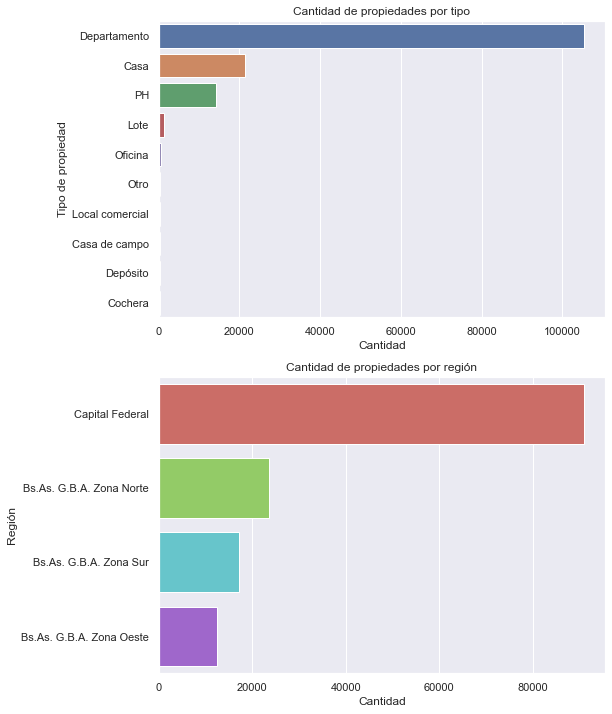

In [20]:
#Visualizamos la cantidad de instancias por tipo de propiedad y región:

#Orden para los tipos de propiedad
tipos_prop = data_propiedades['property_type'].value_counts()
orden_prop = tipos_prop.index

#Orden para la región:
reg_prop = data_propiedades['Región'].value_counts()
orden_reg = reg_prop.index

#Establecemos el tamaño de la figura:
plt.figure(figsize = (8,12))

#Definimos el gráfico para la cantidad de publicaciones por tipo de propiedad:
plt.subplot(2,1,1)
sns.countplot(data = data_propiedades, y = 'property_type', order = orden_prop)
plt.xticks(rotation=0)
plt.ylabel('Tipo de propiedad')
plt.xlabel('Cantidad')
plt.title('Cantidad de propiedades por tipo');

#Definimos el gráfico para la cantidad de publicaciones por región:
plt.subplot(2,1,2)
sns.countplot(data = data_propiedades, y = 'Región', order = orden_reg, palette = 'hls')
plt.xticks(rotation=0)
plt.ylabel('Región')
plt.xlabel('Cantidad')
plt.title('Cantidad de propiedades por región')

plt.show()
#plt.savefig('Propiedades por tipo y region.png')

Por tal motivo, y debido a que uno de los objetivos de este trabajo es mejorar el modelo presentado en la primer entrega, se procede a hacer el mismo filtrado del dataset, esto es, todos los inmuebles de tipo 'Departamento', 'Casa' y 'PH', para la región de Capital Federal:

In [21]:
#En primer lugar, filtramos los tipos de vivienda más populares en un nuevo dataset:

properati = data_propiedades[(data_propiedades.property_type == 'Departamento') | (data_propiedades.property_type == 'Casa') | (data_propiedades.property_type == 'PH')]

#Posteriormente, filtramos las propiedades de Capital Federal (la región con más propiedades publicadas):

properati = properati[properati.Región == 'Capital Federal']

#Por último, imprimimos el shape del nuevo Data Frame filtrado:

print(properati.shape)


(89874, 19)


In [22]:
#Luego, eliminamos las columnas que no van a ser de utilidad para nuestro modelo:

properati.drop(columns = ['País', 'Región', 'title','description', 'operation_type', 'start_date', 'end_date', 'created_on', 'currency'], inplace = True)
properati.shape

(89874, 10)

## 2. Detección y eliminación de outliers

In [154]:
#En primer lugar, obtenemos los datos estadísticos de las variables numéricas de nuestro dataset:
properati.describe()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,89874.000000,89874.000000,89874.000000,89874.000000,89874.000000,89874.000000,89874.000000,8.987400e+04
mean,-34.598840,-58.435395,2.965129,1.960456,1.554534,109.330741,92.350124,2.587195e+05
std,0.023881,0.036252,1.317503,1.074358,0.848511,940.036435,744.796958,3.190762e+05
min,-34.696419,-58.530468,1.000000,0.000000,1.000000,1.000000,1.000000,6.000000e+03
25%,-34.613757,-58.458583,2.000000,1.000000,1.000000,51.000000,46.000000,1.200000e+05
50%,-34.598961,-58.433008,3.000000,2.000000,1.000000,71.759768,63.119485,1.750000e+05
75%,-34.584503,-58.408867,4.000000,3.000000,2.000000,105.000000,92.000000,2.782000e+05
max,-34.535818,-58.353930,26.000000,15.000000,14.000000,126062.000000,126062.000000,3.243423e+07


Podemos ver que muchos de los valores máximos de las columnas no tienen mucho sentido, ya que el 75% de los datos tienen valores muy por debajo de los mismos. Por tal motivo, empezaremos a analizar la distribución de cada una de ellas para eliminar los valores atípicos.

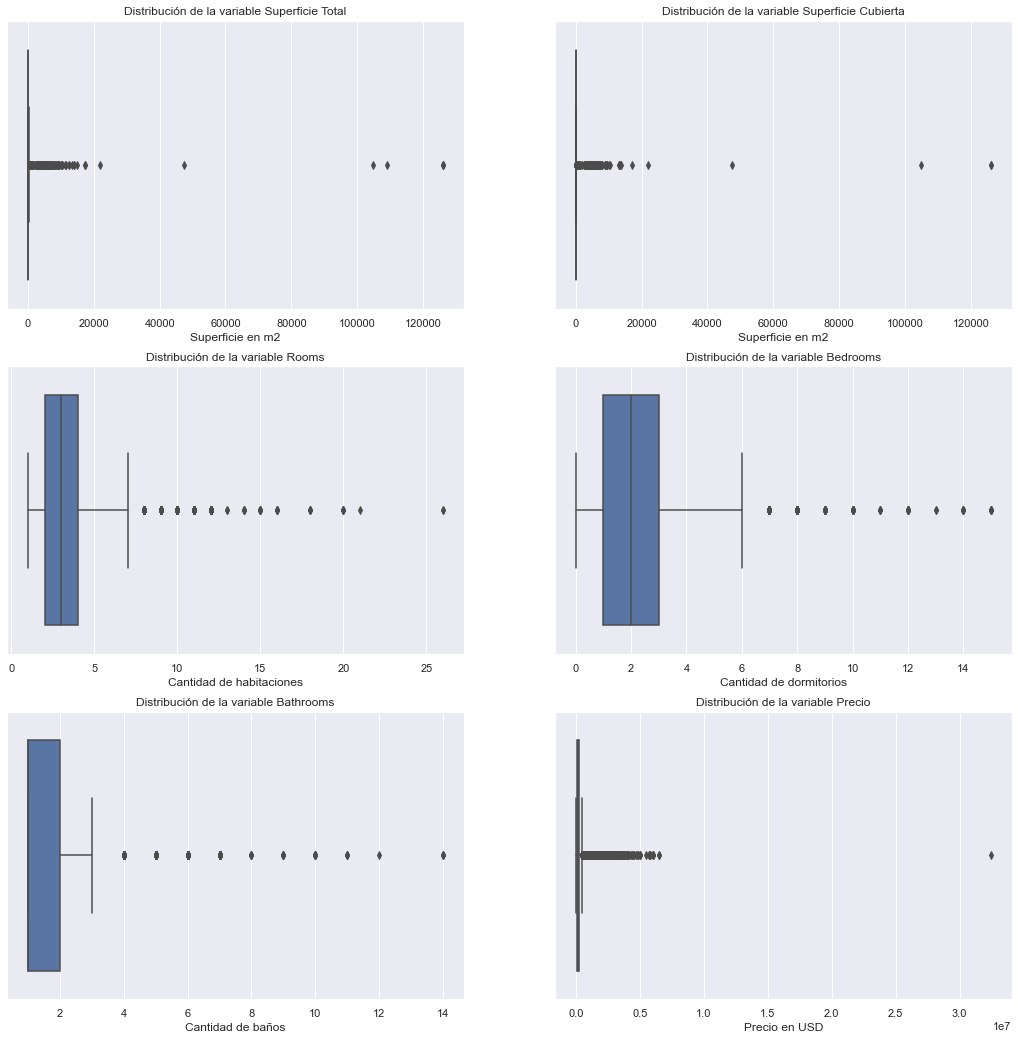

In [155]:
#En primer lugar, analizaremos la distribución de las variables de superficie mediante el uso de boxplots:

#Establecemos el tamaño de la figura:
plt.figure(figsize = (18,18))
sns.set()

#Definimos el gráfico para la variable de superficie total:
plt.subplot(3,2,1)
sns.boxplot(x = properati['surface_total'])
plt.xlabel('Superficie en m2');
plt.title('Distribución de la variable Superficie Total');

#Definimos el gráfico para la variable de superficie cubierta:
plt.subplot(3,2,2)
sns.boxplot(x = properati['surface_covered'])
plt.xlabel('Superficie en m2');
plt.title('Distribución de la variable Superficie Cubierta');

#Definimos el gráfico para la variable 'rooms':
plt.subplot(3,2,3)
sns.boxplot(x = properati['rooms'])
plt.xlabel('Cantidad de habitaciones');
plt.title('Distribución de la variable Rooms');

#Definimos el gráfico para la variable 'bedrooms':
plt.subplot(3,2,4)
sns.boxplot(x = properati['bedrooms'])
plt.xlabel('Cantidad de dormitorios');
plt.title('Distribución de la variable Bedrooms');

#Definimos el gráfico para la variable 'bathrooms':
plt.subplot(3,2,5)
sns.boxplot(x = properati['bathrooms'])
plt.xlabel('Cantidad de baños');
plt.title('Distribución de la variable Bathrooms');

#Definimos el gráfico para la variable 'bathrooms':
plt.subplot(3,2,6)
sns.boxplot(x = properati['price'])
plt.xlabel('Precio en USD')
plt.title('Distribución de la variable Precio')

plt.show()
#plt.savefig('Distribucion de las variables 1.png')

Como se puede ver en todos los casos, todas las variables analizadas contienen valores que distorsionan el análisis, ya que no es muy común un inmueble con 14 baños por ejemplo, por lo que se procederá a eliminarlas del dataset. 

Al igual que se realizó en el apartado anterior, se aplicarán dos criterios:

 - Para las variables 'rooms', 'bedrooms' y 'bathrooms', el **criterio de las tres sigmas**, el cual establece umbrales mínimos y máximos de acuerdo a una función que parte del valor medio de los datos y le adiciona (o resta) el valor de tres desviaciones estándar, valor que se dice que incluye el 99.7 % de los datos.
 - Para las variables de superficie y precio, el **criterio del rango intercuartílico**, el cual establece los umbrales mínimo y máximo a partir de cierta distancia del primer y tercer cuartil, respectivamente.

Una vez más aclaramos que se realiza esta separación de criterios por cuestiones académicas (para utilizar las dos técnicas) y porque las variables de superficie y precio tienen una desviación estándar bastante elevada, por lo que si aplicaramos el criterio de las tres sigmas, la eliminación de outliers no sería muy efectiva.

Para eliminar los valores atípicos del dataset objeto de análisis, utilizaremos las funciones creadas anteriormente:

In [23]:
#Obtenemos las máscaras para cada una de las variables de interés:

mascara_ST = iqr_outliers(properati, 'surface_total') 
mascara_SC = iqr_outliers(properati, 'surface_covered')
mascara_price = iqr_outliers(properati, 'price')
mascara_rooms = sigmas_outliers(properati, 'rooms')
mascara_bedrooms = sigmas_outliers(properati, 'bedrooms')
mascara_bathrooms = sigmas_outliers(properati, 'bathrooms')

#Luego aplicamos todas las máscaras generadas para filtrar el dataset:
properati = properati[mascara_ST & mascara_SC & mascara_price & mascara_rooms & mascara_bedrooms & mascara_bathrooms]
properati.shape

(78206, 10)

Como podemos ver, luego de la eliminación de los outliers nuestro dataset ahora contiene 78.206 instancias.

Otro factor que deberíamos tener en cuenta es que los valores de supeficie cubierta no sean mayores al de superficie total
(ya que es físicamente imposible y no tendría sentido), por lo que vamos a filtrar el dataset nuevamente incluyendo esta condición:

In [24]:
properati = properati[properati.surface_total >= properati.surface_covered]
properati.shape

(77656, 10)

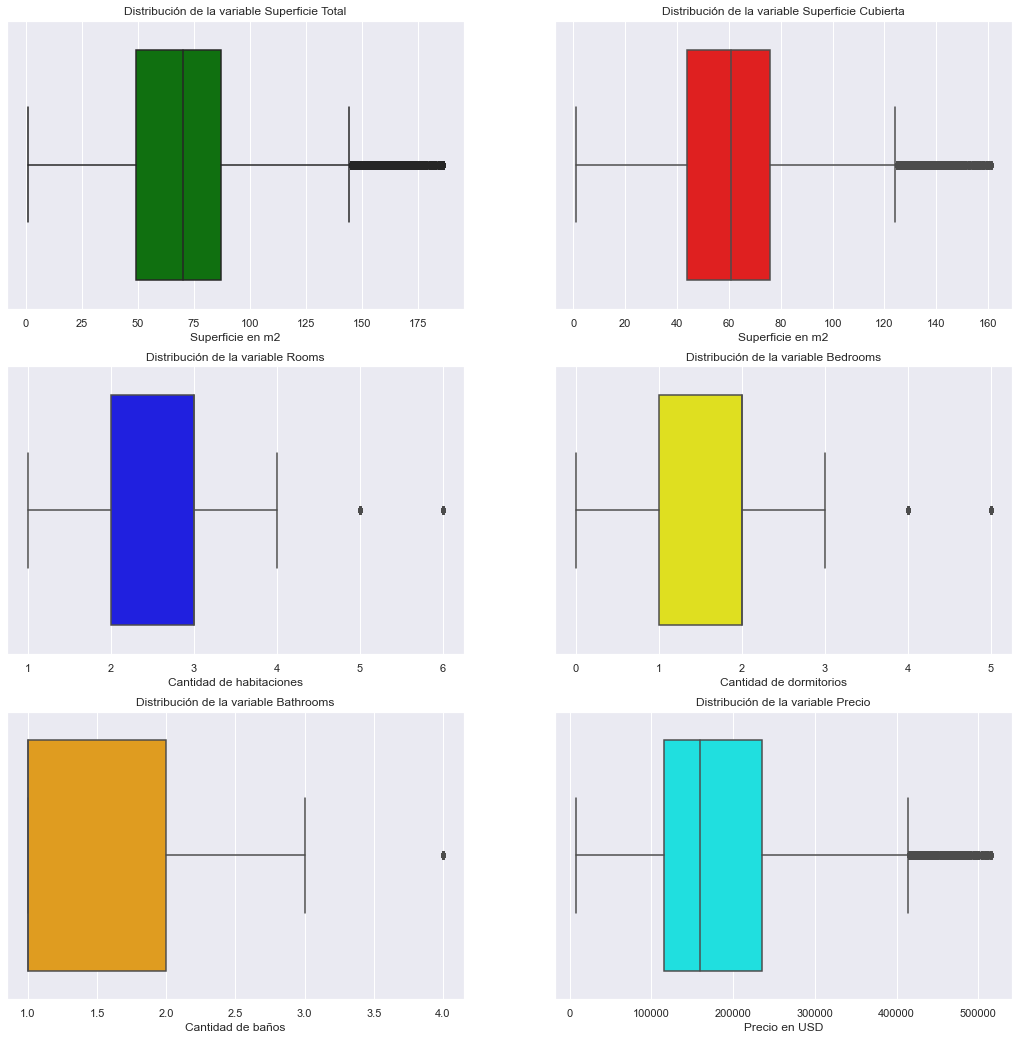

In [158]:
#Volvemos a graficar para analizar la distribución luego del filtrado:

#Establecemos el tamaño de la figura:
plt.figure(figsize = (18,18))
sns.set()

#Definimos el gráfico para la variable de superficie total:
plt.subplot(3,2,1)
sns.boxplot(x = properati['surface_total'], color = 'green')
plt.xlabel('Superficie en m2');
plt.title('Distribución de la variable Superficie Total');

#Definimos el gráfico para la variable de superficie cubierta:
plt.subplot(3,2,2)
sns.boxplot(x = properati['surface_covered'], color = 'red')
plt.xlabel('Superficie en m2');
plt.title('Distribución de la variable Superficie Cubierta');

#Definimos el gráfico para la variable 'rooms':
plt.subplot(3,2,3)
sns.boxplot(x = properati['rooms'], color = 'blue')
plt.xlabel('Cantidad de habitaciones');
plt.title('Distribución de la variable Rooms');

#Definimos el gráfico para la variable 'bedrooms':
plt.subplot(3,2,4)
sns.boxplot(x = properati['bedrooms'], color = 'yellow')
plt.xlabel('Cantidad de dormitorios');
plt.title('Distribución de la variable Bedrooms');

#Definimos el gráfico para la variable 'bathrooms':
plt.subplot(3,2,5)
sns.boxplot(x = properati['bathrooms'], color = 'orange')
plt.xlabel('Cantidad de baños');
plt.title('Distribución de la variable Bathrooms');

#Definimos el gráfico para la variable 'bathrooms':
plt.subplot(3,2,6)
sns.boxplot(x = properati['price'], color = 'cyan')
plt.xlabel('Precio en USD')
plt.title('Distribución de la variable Precio')

plt.show()

Como podemos ver, luego del filtrado de outliers los graficos que muestran la distribución de las variables mejoran notoriamente.

Una vez filtrados los outliers que podían distorsionar nuestro análisis, en el siguiente paso estudiaremos las relaciones de a pares de las variables numéricas a través de un 'pairplot' de Seaborn, con el objetivo de identificar cuál/les de ellas está relacionada a la variable precio, objetivo del modelo de Machine Learning.

In [159]:
#Graficamos las relaciones a pares entre variables, en función al tipo de propiedad:

#sns.pairplot(properati, hue = 'property_type', palette = 'tab10');
#plt.savefig('Relaciones de a pares.png')

Según lo que se puede inferir en el gráfico anterior, las dos variables de superficie presentarían una relación con el precio (ya que al aumentar una, aumenta la otra), por lo cual vamos a comprobar esto analizando la correlación de las variables en el punto siguiente.

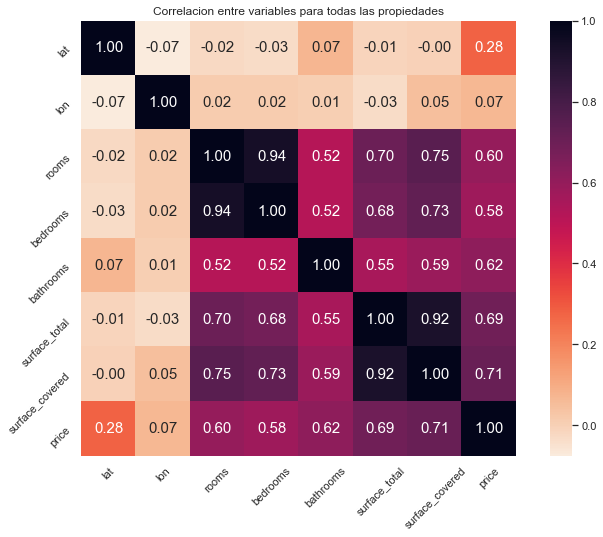

In [160]:
#En primer lugar, calculamos la correlación para nuestro dataset:

corr = properati.drop(columns = ['Barrio','property_type']).corr()

#Luego visualizamos la correlación en las variables a través de un heatmap de Seaborn:

sns.set()
plt.figure(figsize=(12,8))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= properati.drop(columns = ['Barrio','property_type']).columns, 
           yticklabels= properati.drop(columns = ['Barrio','property_type']).columns,
           cmap= 'rocket_r')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.title('Correlacion entre variables para todas las propiedades')
plt.savefig('Correlacion general entre variables.png')
plt.show()

Como podemos ver en el gráfico anterior, las dos variables de mayor correlación con el precio son la ***superficie total*** y ***superficie cubierta***. A continuación analizaremos la misma correlación entre variables, para cada uno de los tipos de propiedad:

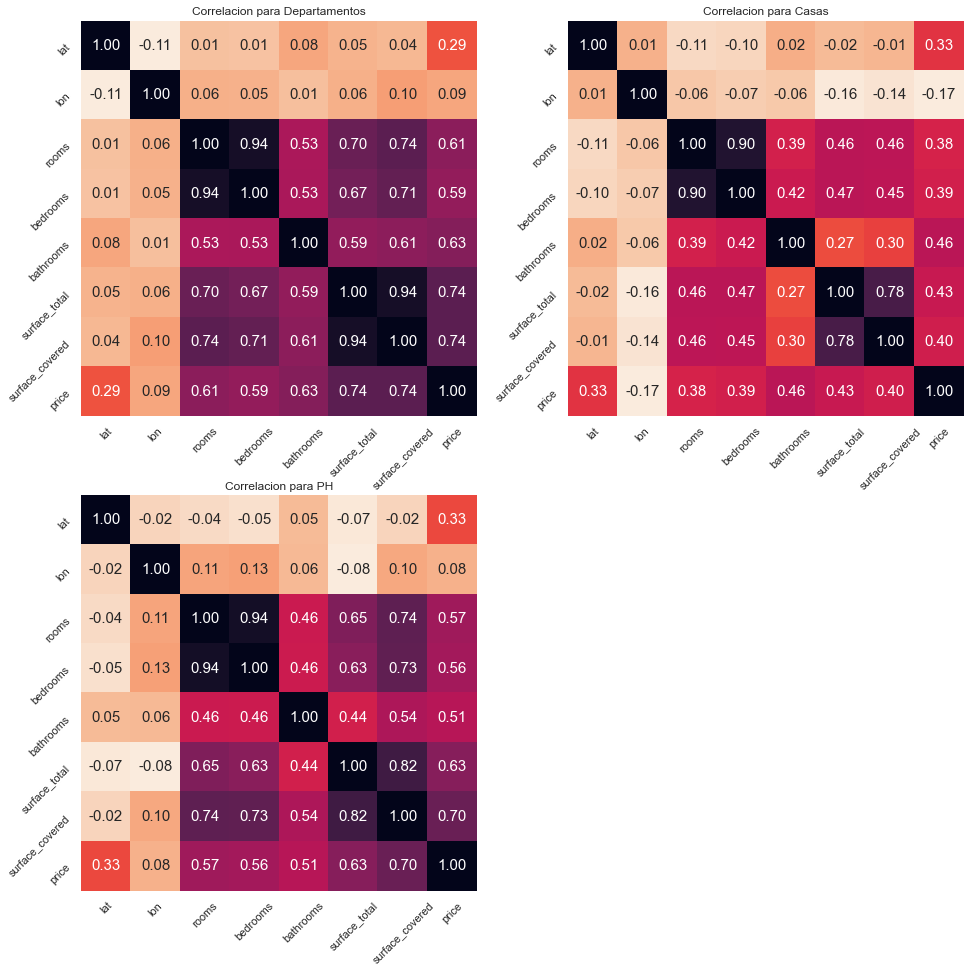

In [161]:
#En primer lugar establecemos las máscaras para filtrar el dataset:

departamentos = properati.property_type == 'Departamento'
casas = properati.property_type == 'Casa'
PH = properati.property_type == 'PH'

#Luego calculamos la correlación entre variables para cada tipo de propiedad:

corr_depto = properati[departamentos].drop(columns = ['Barrio','property_type']).corr()
corr_casa = properati[casas].drop(columns = ['Barrio','property_type']).corr()
corr_PH = properati[PH].drop(columns = ['Barrio','property_type']).corr()

#Por último, graficamos los heatmaps para cada tipo de propiedad:

sns.set()
plt.figure(figsize=(16,16))

#Correlacion entre variables para Departamentos:
plt.subplot(2,2,1)
sns.heatmap(corr_depto, cbar = False,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= properati.drop(columns = ['Barrio','property_type']).columns, 
           yticklabels= properati.drop(columns = ['Barrio','property_type']).columns,
           cmap= 'rocket_r')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.title('Correlacion para Departamentos')

#Correlacion entre variables para Casas:
plt.subplot(2,2,2)
sns.heatmap(corr_casa, cbar = False,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= properati.drop(columns = ['Barrio','property_type']).columns, 
           yticklabels= properati.drop(columns = ['Barrio','property_type']).columns,
           cmap= 'rocket_r')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.title('Correlacion para Casas')

#Correlacion entre variables para PH:
plt.subplot(2,2,3)
sns.heatmap(corr_PH, cbar = False,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= properati.drop(columns = ['Barrio','property_type']).columns,
           cmap= 'rocket_r')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.title('Correlacion para PH')

plt.savefig('Correlación por tipo de propiedad.png')
plt.show()

Al separar el análisis en nuestros tres tipos de propiedad, vemos también que las variables de superficie total y cubierta son las que tienen mayor correlación con el precio para PH y Departamentos, pero no así para las Casas, donde la correlación de la cantidad de baños supera levemente a las variables de superficie.

## 3. Encoding

El dataset con el que estamos trabajando incluye muchas variables categóricas, de las cuales considero como más importantes para nuestro modelo al **barrio** y el **tipo de propiedad**, porque pienso que tienen mucha importancia a la hora de determinar el precio de una propiedad. En este punto del trabajo, convertiremos a las mismas a valores numéricos, con el objetivo de que el modelo pueda utilizarlas y aprender de ellas, y por ende mejorar su desempeño.

Para llevar esto a cabo, aplicaremos el procedimiento conocido como **One Hot Encoding** sobre la variable **'property_type'** únicamente, ya que de aplicarlo sobre la variable **'Barrio'** nuestro dataset crecería a niveles innecesarios, por lo que para dicha variable aplicaremos un procedimiento alternativo: crear una columna llamada **'Precio_promedio_m2_Barrio'** donde incluiremos el valor promedio del metro cuadrado por barrio, de modo de intentar que el modelo identifique la diferencia de precios que puede haber de acuerdo al barrio donde se localice el inmueble.

In [25]:
#En primer lugar, convertimos los valores de la columna 'property_type' a valores numéricos, en un nuevo dataset: 

properati_ML = pd.get_dummies(properati, columns=['property_type'])
properati_ML.head()

,Barrio,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type_Casa,property_type_Departamento,property_type_PH
1,Boedo,-34.624056,-58.412110,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,1
2,Palermo,-34.593569,-58.427474,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,1
3,Palermo,-34.581294,-58.436754,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,1
5,Villa Crespo,-34.593779,-58.441239,2.0,1.0,1.0,56.0,56.0,150000.0,0,0,1
6,Villa Crespo,-34.600988,-58.433061,2.0,1.0,1.0,70.0,70.0,159500.0,0,0,1


Como podemos ver, este método nos devuelve un dataset donde la columna 'property_type' fue reemplazada por otras tres columnas, una por tipo de propiedad.

A continuación incluiremos una columna nueva en el dataset que incluya el valor promedio del metro cuadrado por barrio, de modo de tratar de asignar numéricamente el peso o importancia de cada barrio:

In [26]:
#En primer lugar, calculamos el valor del metro cuadrado por inmueble:
properati_ML['Precio por m2'] = properati_ML['price'] / properati_ML['surface_total']

#Calculamos el valor promedio del m2 por barrio:
promedio_m2_barrio = properati_ML.groupby('Barrio').agg({'Precio por m2':'mean'})

#Convertimos los valores obtenidos a un diccionario:
dicc_promedio_m2_barrio = promedio_m2_barrio.to_dict()['Precio por m2']

#Por último, creamos una nueva columna en el dataset que contenga dichos valores promedio:
properati_ML['Precio_promedio_m2_Barrio'] = properati_ML.Barrio.map(dicc_promedio_m2_barrio)

properati_ML.head()

,Barrio,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type_Casa,property_type_Departamento,property_type_PH,Precio por m2,Precio_promedio_m2_Barrio
1,Boedo,-34.624056,-58.412110,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,1,2271.428571,2053.631346
2,Palermo,-34.593569,-58.427474,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,1,2777.777778,3210.083120
3,Palermo,-34.581294,-58.436754,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,1,3470.588235,3210.083120
5,Villa Crespo,-34.593779,-58.441239,2.0,1.0,1.0,56.0,56.0,150000.0,0,0,1,2678.571429,2467.393712
6,Villa Crespo,-34.600988,-58.433061,2.0,1.0,1.0,70.0,70.0,159500.0,0,0,1,2278.571429,2467.393712


### 4. Comparación con los modelos de Machine Learning del Proyecto 1

En este punto se trabajarán los mismos 3 modelos de Machine Learning presentados en el Proyecto 1: un modelo Benchmark de Regresión Lineal, un Árbol de Decisión y un modelo de Vecinos más cercanos, pero esta vez los mismos se entrenarán con el set de datos transformado según los apartados anteriores, con el objeto de comparar el desempeño de los mismos.

Como ya bien sabemos, nuestra variable a predecir es el precio (y) y las variables que se utilizarán como predictoras del mismo, o también conocidas como atributos (X), son, en primer lugar y para comparar con los modelos de la primer entrega, la Superficie Total y Cubierta. Luego, se realizará un nuevo análisis de los modelos incluyendo los otros atributos del dataset.

La métrica que se utilizará para evaluar el desempeño del modelo es **Raíz del error cuadrado promedio (RMSE)**, la cual es una métrica de error, por lo que a más bajo RMSE, mejor desempeño tendrá el modelo.

Cabe aclarar que los modelos de Árbol de Decisión y Vecinos más cercanos se entrenarán en primer lugar con los hiperparámetros que daban un mejor desempeño en la primer entrega, y luego se realizará nuevamente una optimización manual de hiperparámteros, con el objeto de encontrar el mejor desempeño.

A continuación se exponen los resultados de RMSE obtenidos en la primer entrega:

In [59]:
#Creamos un diccionario con los resultados obtenidos en el primer proyecto:
resultados = {'Modelo':['Regresión lineal', 'Regresión lineal', 'Árbol de decisión', 'Árbol de decisión', 'Vecinos más cercanos', 'Vecinos más cercanos'], 
              'Grupo':['Train', 'Test', 'Train', 'Test', 'Train', 'Test'], 
              'RMSE':[216278.717594025, 218957.054217952, 172206.163531509, 179300.315344009, 155108.882451521, 171623.252411775]}

#Incluimos dichos resultados en un dataframe para mejor visualización:
tabla_resultados = pd.DataFrame(resultados)
tabla_resultados

,Modelo,Grupo,RMSE
0,Regresión lineal,Train,216278.717594
1,Regresión lineal,Test,218957.054218
2,Árbol de decisión,Train,172206.163532
3,Árbol de decisión,Test,179300.315344
4,Vecinos más cercanos,Train,155108.882452
5,Vecinos más cercanos,Test,171623.252412


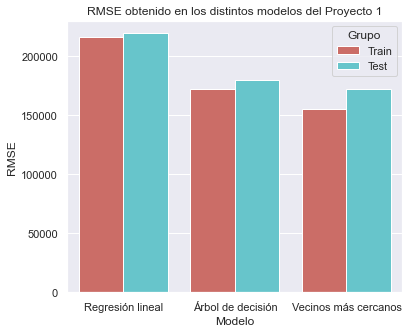

In [60]:
#Observamos los resultados del proyecto 1 gráficamente:
plt.figure(figsize=(6,5))
sns.barplot(data = tabla_resultados, x = 'Modelo', y = 'RMSE', hue = 'Grupo', palette = 'hls')
plt.title('RMSE obtenido en los distintos modelos del Proyecto 1');

Como podemos ver, el modelo que obtenía un mejor RMSE tanto en los grupos de entrenamiento como prueba era el de Vecinos más cercanos.

A continuación crearemos una función que utilizaremos para entrenar y evaluar gráfica y numéricamente (a través del RMSE) los modelos:

In [35]:
def aplicar_modelo(modelo,X_train, X_test, y_train, y_test):
    '''Dado un modelo que ingresamos como parámetro, esta función entrena los datos, realiza una predicción sobre los grupos de
    entrenamiento y prueba y luego evalúa el desempeño del mismo sobre ambos grupos'''
    
    #En primer lugar, entrenamos el modelo con los datos de 
    modelo.fit(X_train, y_train)

    #Predecimos la los valores de la variable 'y' sobre los grupos de entrenamiento y prueba:
    y_train_pred = modelo.predict(X_train)
    y_test_pred = modelo.predict(X_test)

    #Por último, evaluamos el modelo utilizando la métrica elegida (RMSE):
    from sklearn.metrics import mean_squared_error

    rmse_train = mean_squared_error(y_train, y_train_pred, squared = False)
    rmse_test = mean_squared_error(y_test, y_test_pred, squared = False)
    print(f'Raíz del error cuadrado promedio en Train: {rmse_train}')
    print(f'Raíz del error cuadrado promedio en Test: {rmse_test}')
    
    #Visualizamos el desempeño del modelo:
    sns.set()
    plt.figure(figsize = (8,4))

    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 30, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 30, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)    
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),np.max([ax.get_xlim(), ax.get_ylim()])]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')

    plt.tight_layout()
    plt.show()

Por último, definimos las variables que utilizaremos, en primer lugar, como predictoras de nuestro modelo:

In [62]:
#Seleccionamos las variables predictoras o atributos (X) y la variable a predecir (y):

X = properati_ML[['surface_total', 'surface_covered']]
y = properati_ML['price']

#Luego seleccionamos el 70% de los datos de X e y como grupo de entrenamiento (train) y el 30% como grupo de prueba (test) del modelo:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Modelo Benchmark: Regresión Lineal

Raíz del error cuadrado promedio en Train: 64963.648778656345
Raíz del error cuadrado promedio en Test: 64767.09075384715


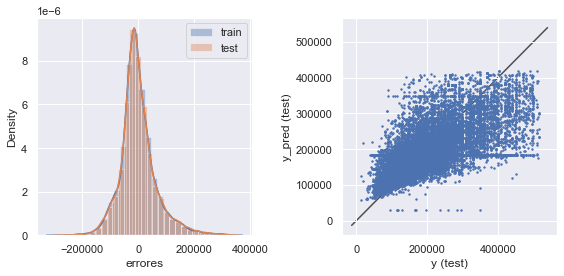

In [63]:
#Creamos el modelo:
from sklearn.linear_model import LinearRegression

regresion_lineal = LinearRegression()

#Luego, entrenamos y evaluamos el modelo a través de la función creada anteriormente:

aplicar_modelo(regresion_lineal,X_train, X_test, y_train, y_test)

Esto nos quiere decir que el modelo de regresión lineal estaría estimando el precio de las propiedades en ambos grupos (Train y Test) con un error de casi USD 65.000, valor muy inferior al que obtuvimo anteriormente, por lo cual el desempeño del modelo ha mejorado considerablemente.

## Modelo 1: Árbol de decisión

Raíz del error cuadrado promedio en Train: 62208.097275067325
Raíz del error cuadrado promedio en Test: 62334.64832950451


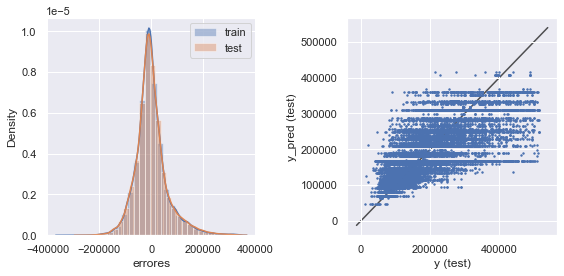

In [64]:
#En primer lugar, creamos el modelo de Árbol de decisión, con una máxima profundidad (hiperparámetro max_depth) de 7:
from sklearn.tree import DecisionTreeRegressor

regresion_tree = DecisionTreeRegressor(max_depth=7, random_state=42)

#Luego, entrenamos y evaluamos el modelo a través de la función creada anteriormente:

aplicar_modelo(regresion_tree,X_train, X_test, y_train, y_test)

Esto nos quiere decir que el modelo de regresión de Árbol de decisión estaría estimando el precio de las propiedades en ambos grupos (Train y Test) con un error un poco menor al anterior, ya que ambos se encuentran por debajo de los USD 63.000, por ende tiene un mejor desempeño.

El hiperparámetro de máxima profundidad utilizado en el modelo fue seleccionado arbitrariamente, por lo que a continuación se realizará una optimización manual del mismo, con el objeto de encontrar el que nos de el mejor desempeño para los grupos de entrenamiento y prueba:

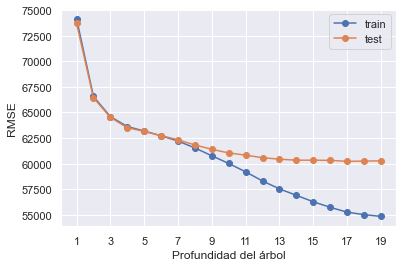

In [65]:
from sklearn.metrics import mean_squared_error

# Definimos las listas vacias para los valores de RMSE deseados:
lista_RMSE_train = []
lista_RMSE_test = []

# Definimos la lista de valores de max_depth que vamos a explorar:
max_depths = list(np.arange(1,20))

# Generamos un loop sobre los distintos valores de profundidad:
for max_depth in max_depths:
        
    # Definir el modelo con el valor de profundidad
    regresion_tree1 = DecisionTreeRegressor(max_depth = max_depth, random_state=42)
    
    # Entrenar el modelo
    regresion_tree1.fit(X_train,y_train)
    
    # Predecir y evaluar sobre el set de entrenamiento
    y_train_pred1 = regresion_tree1.predict(X_train)
    train_RMSE = mean_squared_error(y_train, y_train_pred1, squared = False)
    
    # Predecir y evaluar sobre el set de evaluación
    y_test_pred1 = regresion_tree1.predict(X_test)
    test_RMSE = mean_squared_error(y_test, y_test_pred1, squared = False)
    
    # Agregar la información a las listas
    lista_RMSE_train.append(train_RMSE)
    lista_RMSE_test.append(test_RMSE)

#Luego analizamos el desempeño del modelo para los distintos valores de profundidad gráficamente:

sns.set()
plt.plot(max_depths,lista_RMSE_train,'o-',label='train')
plt.plot(max_depths,lista_RMSE_test,'o-',label='test')
plt.xticks(np.arange(1,20,2))
plt.legend()
plt.xlabel('Profundidad del árbol');
plt.ylabel('RMSE');

Como se puede observar en el gráfico,  hasta el nivel de profundidad 9 el desempeño del modelo es casi igual para los grupos de entrenamiento y prueba, y a partir de dicho valor el modelo empieza a sobreajustar sobre los datos de entrenamiento, sin reducir sustancialmente el error sobre el grupo de prueba, por lo que es razonable fijar dicho valor como hiperparámtero. Dicho esto, a continuación se expone el modelo incluyendo este valor de hiperparámetro y se analiza numéricamente el resultado:

Raíz del error cuadrado promedio en Train: 60769.40697600125
Raíz del error cuadrado promedio en Test: 61399.4137423637


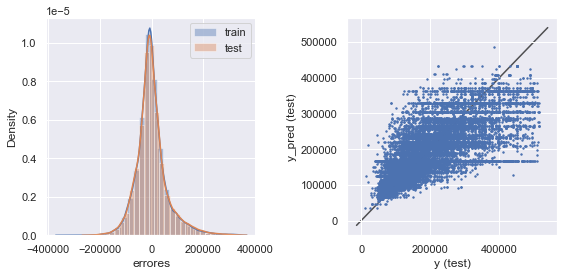

In [66]:
#Creamos el modelo de Árbol de decisión, con una máxima profundidad (hiperparámetro max_depth) de 9:

regresion_tree = DecisionTreeRegressor(max_depth=9, random_state=42)

#Luego, entrenamos y evaluamos el modelo a través de la función creada anteriormente:

aplicar_modelo(regresion_tree,X_train, X_test, y_train, y_test)

Como podemos ver, al cambiar el valor del hiperparámetro en nuestro modelo mejoró levemante su desempeño en ambos grupos.

# Modelo 2: Vecinos más cercanos

Raíz del error cuadrado promedio en Train: 59268.01615562455
Raíz del error cuadrado promedio en Test: 61404.08344927374


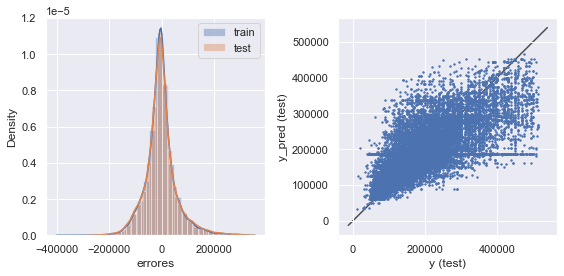

In [67]:
#En primer lugar, creamos el modelo de Vecinos más cercanos, con una cantidad de vecinos (hiperparámetro n_neighbors) de 10:
from sklearn.neighbors import KNeighborsRegressor

regresion_KNN = KNeighborsRegressor(n_neighbors=10)

#Luego, entrenamos y evaluamos el modelo a través de la función creada anteriormente:

aplicar_modelo(regresion_KNN,X_train, X_test, y_train, y_test)

Al analizar los resultados obtenidos, observamos que este modelo tuvo un desempeño muy similar al anterior, ya que también se obtuvieron valores de RMSE para los grupos de entrenamiento y prueba por debajo de los USD 62.000.

Al igual que en el modelo de Árbol de decisión, el hiperparámetro utilizado en el modelo (n_neighbors) fue seleccionado arbitrariamente, por lo que a continuación se compararán diversos valores que puede tomar este parámetro, y el desempeño del modelo (a través de la métrica RMSE) en cada uno de ellos.

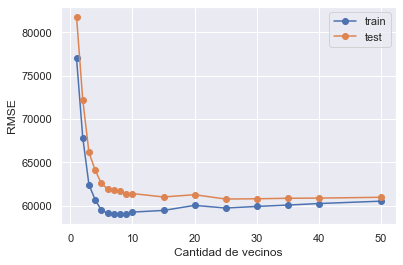

In [68]:
# Definimos las listas vacias para los valores de RMSE deseados:
lista_RMSE_train1 = []
lista_RMSE_test1 = []

# Definimos la lista de valores de k (número de vecinos) que vamos a explorar:
k_vecinos = [1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,50]

# Generamos en loop sobre los distintos valores de k: 
for k in k_vecinos:
    
    # Definir el modelo con el valor de vecinos deseado
    regresion_KNN1 = KNeighborsRegressor(n_neighbors = k)
    
    # Entrenar el modelo
    regresion_KNN1.fit(X_train,y_train)
    
    # Predecir y evaluar sobre el set de entrenamiento
    y_train_pred2 = regresion_KNN1.predict(X_train)
    train_RMSE1 = mean_squared_error(y_train, y_train_pred2, squared = False)
    
    # Predecir y evaluar sobre el set de evaluación
    y_test_pred2 = regresion_KNN1.predict(X_test)
    test_RMSE1 = mean_squared_error(y_test, y_test_pred2, squared = False)
    
    # Agregar la información a las listas
    lista_RMSE_train1.append(train_RMSE1)
    lista_RMSE_test1.append(test_RMSE1)

#Luego analizamos el desempeño del modelo para las distintos números de vecinos gráficamente:

sns.set()
plt.plot(k_vecinos,lista_RMSE_train1,'o-',label='train')
plt.plot(k_vecinos,lista_RMSE_test1,'o-',label='test')
plt.legend()
plt.xlabel('Cantidad de vecinos');
plt.ylabel('RMSE');

Como se puede observar en el gráfico, un valor razonable para el hiperparámtero de cantidad de vecinos podría ser 15, ya que con él se obtiene un valor de RMSE relativamente bajo y no existe tanta diferencia entre los desempeños de los grupos de entrenamiento y prueba. Esto nos dice que el modelo no estaría sobreajustando sobre los datos de entrenamiento, situación que se daba anteriormente al existir mayor diferencia entre los RMSE de ambos grupos. Dicho esto, a continuación se expone el modelo incluyendo este valor de hiperparámetro y se analiza numéricamente el resultado:

Raíz del error cuadrado promedio en Train: 59457.79414576707
Raíz del error cuadrado promedio en Test: 61013.44255479998


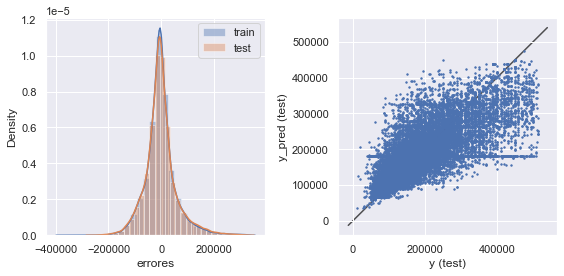

In [69]:
#En primer lugar, creamos el modelo de Vecinos más cercanos, con una cantidad de vecinos (hiperparámetro n_neighbors) de 15:
from sklearn.neighbors import KNeighborsRegressor

regresion_KNN = KNeighborsRegressor(n_neighbors = 15)

#Luego, entrenamos y evaluamos el modelo a través de la función creada anteriormente:

aplicar_modelo(regresion_KNN,X_train, X_test, y_train, y_test)

Al ver los números obtenidos podemos concluir que al utilizar 15 vecinos, se obtiene un RMSE aún menor, y disminuye la varianza al aplicar el modelo sobre los datos de prueba, por lo tanto, sería el modelo con mejor desempeño hasta el momento.

Con el objeto de comparar con los resultados obtenidos en el primer proyecto, a continuación se exponen los resultados obtenidos hasta el momento:

In [70]:
#Creamos un diccionario con los resultados obtenidos hasta el momento:
resultados1 = {'Modelo':['Regresión lineal', 'Regresión lineal', 'Árbol de decisión', 'Árbol de decisión', 'Vecinos más cercanos', 'Vecinos más cercanos'], 
              'Grupo':['Train', 'Test', 'Train', 'Test', 'Train', 'Test'], 
              'RMSE':[64963.648778656345, 64767.09075384715, 60769.40697600125, 61399.4137423637, 59457.79414576707, 61013.44255479998]}

#Incluimos dichos resultados en un dataframe para mejor visualización:
tabla_resultados1 = pd.DataFrame(resultados1)
tabla_resultados1

,Modelo,Grupo,RMSE
0,Regresión lineal,Train,64963.648779
1,Regresión lineal,Test,64767.090754
2,Árbol de decisión,Train,60769.406976
3,Árbol de decisión,Test,61399.413742
4,Vecinos más cercanos,Train,59457.794146
5,Vecinos más cercanos,Test,61013.442555


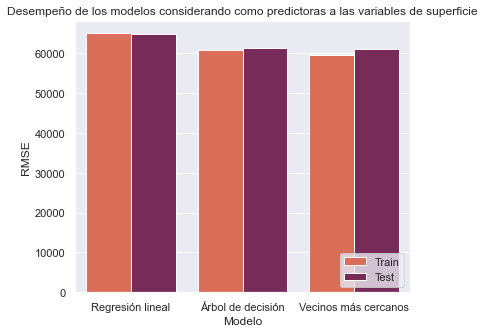

In [71]:
#Observamos los resultados del proyecto 1 gráficamente:
plt.figure(figsize=(6,5))
sns.barplot(data = tabla_resultados1, x = 'Modelo', y = 'RMSE', hue = 'Grupo', palette = 'rocket_r')
plt.legend(loc='lower right') 
plt.title('Desempeño de los modelos considerando como predictoras a las variables de superficie');

Como podemos ver en el gráfico anterior, el modelo que sigue mostrando un mejor desempeño es el de Vecinos más cercanos, con un RMSE inferior a los USD 62.000.

En la siguiente parte del trabajo se vuelven a entrenar todos los modelos, pero esta vez incluyendo más atributos para predecir el precio, y se evalúan los resultados de los mismos:

In [29]:
#Seleccionamos las variables predictoras o atributos (X) y la variable a predecir (y):

X = properati_ML[['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms','surface_total', 'surface_covered','property_type_Casa',
       'property_type_Departamento', 'property_type_PH', 'Precio_promedio_m2_Barrio']]

y = properati_ML['price']

#Luego seleccionamos el 70% de los datos de X e y como grupo de entrenamiento (train) y el 30% como grupo de prueba (test) del modelo:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

Asimismo, se incluirá un análisis aplicando los modelos sobre los datos reescalados.

In [30]:
#En primer lugar, creamos una copia del dataset:

properati_escalado = properati_ML.copy()

#Seleccionamos las columnas que vamos a reescalar:

col_esc = properati_escalado[['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms','surface_total', 'surface_covered',
                        'Precio_promedio_m2_Barrio']]

#Importamos el escalador:
from sklearn.preprocessing import StandardScaler

escalador = StandardScaler()

#Reeplazamos por los valores escalados en el nuevo dataset:

properati_escalado[['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms','surface_total', 'surface_covered',
                        'Precio_promedio_m2_Barrio']] = escalador.fit_transform(col_esc)

#Seleccionamos las variables predictoras o atributos (X) y la variable a predecir (y), para los datos reescalados:

X1 = properati_escalado[['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms','surface_total', 'surface_covered','property_type_Casa',
       'property_type_Departamento', 'property_type_PH', 'Precio_promedio_m2_Barrio']]

y1 = properati_escalado['price']

#Luego seleccionamos el 70% de los datos de X e y como grupo de entrenamiento (train) y el 30% como grupo de prueba (test) del modelo:
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.30, random_state=42)

In [74]:
properati_escalado.head()

,Barrio,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type_Casa,property_type_Departamento,property_type_PH,Precio por m2,Precio_promedio_m2_Barrio
1,Boedo,-1.052863,0.701006,-0.684151,-0.861845,1.030640,-0.085032,-0.228474,159000.0,0,0,1,2271.428571,-1.126069
2,Palermo,0.243394,0.265918,-0.684151,-0.861845,-0.613129,-0.858403,-0.707416,125000.0,0,0,1,2777.777778,0.856179
3,Palermo,0.765310,0.003115,-0.684151,-0.861845,-0.613129,0.378992,-0.523207,295000.0,0,0,1,3470.588235,0.856179
5,Villa Crespo,0.234463,-0.123890,-0.684151,-0.861845,-0.613129,-0.518120,-0.302157,150000.0,0,0,1,2678.571429,-0.416848
6,Villa Crespo,-0.072058,0.107686,-0.684151,-0.861845,-0.613129,-0.085032,0.213626,159500.0,0,0,1,2278.571429,-0.416848


## Ex modelo Benchmark: Regresión Lineal - incluyendo todos los atributos del dataset

Raíz del error cuadrado promedio en Train: 49777.80376025147
Raíz del error cuadrado promedio en Test: 49584.6467771613


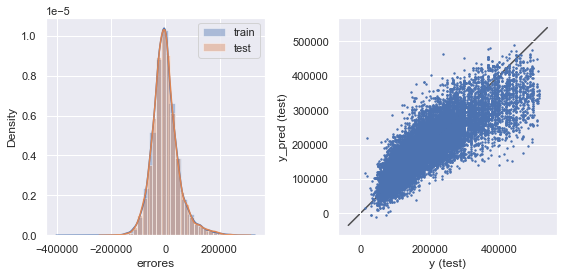

In [75]:
#Creamos el modelo:

regresion_lineal = LinearRegression()

#Luego, entrenamos y evaluamos el modelo a través de la función creada anteriormente:

aplicar_modelo(regresion_lineal, X_train, X_test, y_train, y_test)

Raíz del error cuadrado promedio en Train: 49777.80376025153
Raíz del error cuadrado promedio en Test: 49584.646777161244


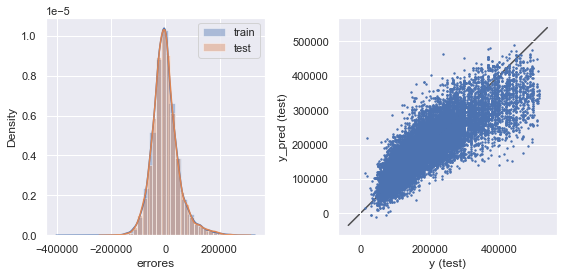

In [76]:
#Aplicamos el modelo sobre los datos escalados:

aplicar_modelo(regresion_lineal, X_train1, X_test1, y_train1, y_test1)

Como podemos ver, el desempeño del modelo mejoró considerablemente al incluir los otros atributos del dataset, disminuyendo el RMSE por debajo de los USD 50.000, y no existe diferencia en el desempeño al utilizar los datos escalados.

## Modelo 1: Árbol de decisión - incluyendo todos los atributos del dataset

Raíz del error cuadrado promedio en Train: 40256.746315584474
Raíz del error cuadrado promedio en Test: 42090.26923148731


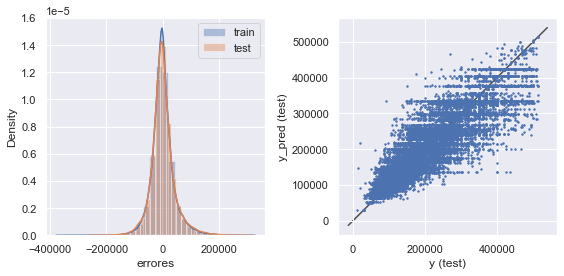

In [77]:
#Creamos el modelo de Árbol de decisión, con una máxima profundidad (hiperparámetro max_depth) de 9:

regresion_tree = DecisionTreeRegressor(max_depth=9, random_state=42)

#Luego, entrenamos y evaluamos el modelo a través de la función creada anteriormente:

aplicar_modelo(regresion_tree,X_train, X_test, y_train, y_test)

Aplicamos nuevamente una optimización manual del hiperparámetro 'max_depth':

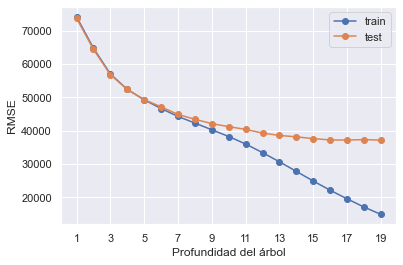

In [49]:
from sklearn.metrics import mean_squared_error

# Definimos las listas vacias para los valores de RMSE deseados:
lista_RMSE_train = []
lista_RMSE_test = []

# Definimos la lista de valores de max_depth que vamos a explorar:
max_depths = list(np.arange(1,20))

# Generamos un loop sobre los distintos valores de profundidad:
for max_depth in max_depths:
        
    # Definir el modelo con el valor de profundidad
    regresion_tree1 = DecisionTreeRegressor(max_depth = max_depth, random_state=42)
    
    # Entrenar el modelo
    regresion_tree1.fit(X_train,y_train)
    
    # Predecir y evaluar sobre el set de entrenamiento
    y_train_pred1 = regresion_tree1.predict(X_train)
    train_RMSE = mean_squared_error(y_train, y_train_pred1, squared = False)
    
    # Predecir y evaluar sobre el set de evaluación
    y_test_pred1 = regresion_tree1.predict(X_test)
    test_RMSE = mean_squared_error(y_test, y_test_pred1, squared = False)
    
    # Agregar la información a las listas
    lista_RMSE_train.append(train_RMSE)
    lista_RMSE_test.append(test_RMSE)
    
#Luego analizamos el desempeño del modelo para los distintos valores de profundidad gráficamente:

sns.set()
plt.plot(max_depths,lista_RMSE_train,'o-',label='train')
plt.plot(max_depths,lista_RMSE_test,'o-',label='test')
plt.xticks(np.arange(1,20,2))
plt.legend()
plt.xlabel('Profundidad del árbol');
plt.ylabel('RMSE');

Nuevamente observamos que fijar en 9 el valor de profundidad del árbol nos da un valor relativamente bajo de RMSE, y no existe un sobreajuste al aplicar el modelo sobre los datos de prueba.

A continuación analizaremos la importancia de los atributos a la hora de realizar la predicción:

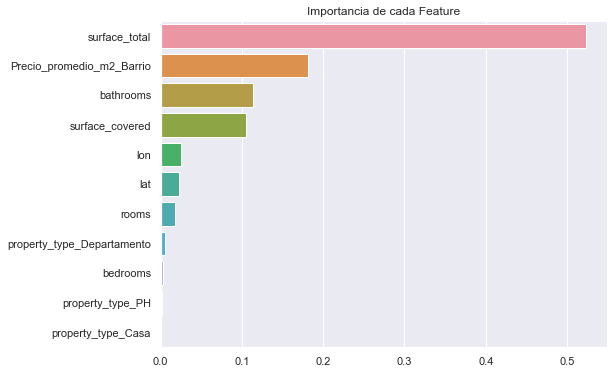

In [38]:
#Analizamos visualmente la importancia de cada atributo en la predicción:

importances = regresion_tree.feature_importances_
columns = X.columns

#Establecemos el orden en que queremos visualizar el gráfico, creando un diccionario con las columnas y sus respectivos valores:
lista_importances = list(importances)
lista_columnas = list(columns)
dicc = dict(zip(lista_columnas,lista_importances))

#Ordenamos los valores del diccionario
import operator
dicc = sorted(dicc.items(), key=operator.itemgetter(1), reverse = True)

#Establecemos la lista con el orden de importancia de atributos:
orden = []
for columna, valor in dicc:
    orden.append(columna)

plt.figure(figsize=(8,6))
sns.barplot(importances, columns, order = orden)
plt.xticks(rotation=0)
plt.title('Importancia de cada Feature')
plt.show()

Como podemos ver en el gráfico anterior, la variable superficie total sigue siendo la más importante a la hora de determinar el precio del inmueble (con una importancia superior al 50 %), pero cabe destacar que la sigue en importancia la representación numérica de la variable Barrio ('Precio_promedio_m2_Barrio'), por lo cual el modelo estaría considerando la diferencia de precio que puede haber entre los distintos barrios a la hora de predecir, mejorando su desempeño y por ende disminuyendo el RMSE.

Otro punto a tener en cuenta es que la variable superficie cubierta quedó en cuarto lugar en importancia luego de incorporar otros atributos, siendo ahora superada por la cantidad de baños del inmueble.

Raíz del error cuadrado promedio en Train: 40256.603605559416
Raíz del error cuadrado promedio en Test: 42105.37752663443


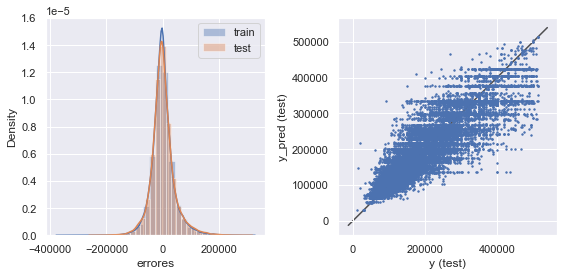

In [78]:
#Aplicamos el modelo sobre los datos reescalados:

aplicar_modelo(regresion_tree,X_train1, X_test1, y_train1, y_test1)

En conclusión, en el caso de este modelo observamos una vez más que al incluir otros atributos mejora el desempeño del modelo, obteniendo un RMSE más bajo, y que al aplicar el modelo sobre los datos reescalados no se genera una diferencia considerable en el desempeño del mismo.

## Modelo 2: Vecinos más cercanos - incluyendo todos los atributos del dataset

Raíz del error cuadrado promedio en Train: 37582.30034640183
Raíz del error cuadrado promedio en Test: 40599.6727600626


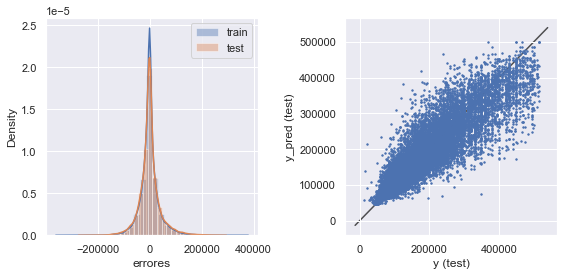

In [79]:
#En primer lugar, creamos el modelo de Vecinos más cercanos, con una cantidad de vecinos (hiperparámetro n_neighbors) de 15:
from sklearn.neighbors import KNeighborsRegressor

regresion_KNN = KNeighborsRegressor(n_neighbors = 15)

#Luego, entrenamos y evaluamos el modelo a través de la función creada anteriormente:

aplicar_modelo(regresion_KNN,X_train, X_test, y_train, y_test)

Aplicamos nuevamente una optimización manual del hiperparámetro 'n_neighbors', con el objeto de descubrir si al incluir nuevos atributos al modelo, cambia la cantidad óptima de vecinos a considerar:

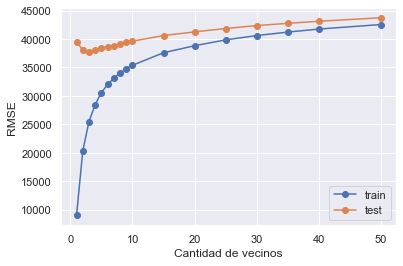

In [53]:
# Definimos las listas vacias para los valores de RMSE deseados:
lista_RMSE_train1 = []
lista_RMSE_test1 = []

# Definimos la lista de valores de k (número de vecinos) que vamos a explorar:
k_vecinos = [1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,50]

# Generamos en loop sobre los distintos valores de k: 
for k in k_vecinos:
    
    # Definir el modelo con el valor de vecinos deseado
    regresion_KNN1 = KNeighborsRegressor(n_neighbors = k)
    
    # Entrenar el modelo
    regresion_KNN1.fit(X_train,y_train)
    
    # Predecir y evaluar sobre el set de entrenamiento
    y_train_pred2 = regresion_KNN1.predict(X_train)
    train_RMSE1 = mean_squared_error(y_train, y_train_pred2, squared = False)
    
    # Predecir y evaluar sobre el set de evaluación
    y_test_pred2 = regresion_KNN1.predict(X_test)
    test_RMSE1 = mean_squared_error(y_test, y_test_pred2, squared = False)
    
    # Agregar la información a las listas
    lista_RMSE_train1.append(train_RMSE1)
    lista_RMSE_test1.append(test_RMSE1)

#Luego analizamos el desempeño del modelo para las distintos números de vecinos gráficamente:

sns.set()
plt.plot(k_vecinos,lista_RMSE_train1,'o-',label='train')
plt.plot(k_vecinos,lista_RMSE_test1,'o-',label='test')
plt.legend()
plt.xlabel('Cantidad de vecinos');
plt.ylabel('RMSE');

En este caso observamos que al utilizar 15 vecinos, se obtiene mayor nivel de error tanto en los grupos de entrenamiento como de prueba, por lo que podríamos cambiar el valor de este hiperparámetro a 10 vecinos y observar el desempeño del modelo:

Raíz del error cuadrado promedio en Train: 35375.22431814718
Raíz del error cuadrado promedio en Test: 39618.90096953789


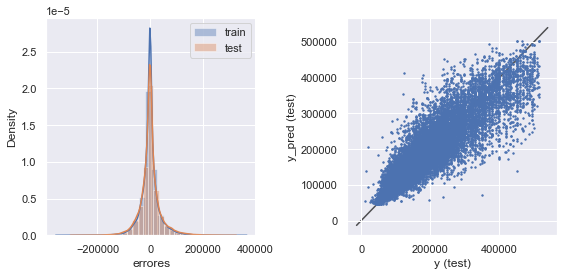

In [80]:
#Cambiamos el valor del hiperparámetro en nuestro modelo:
regresion_KNN = KNeighborsRegressor(n_neighbors = 10)

#Luego, entrenamos y evaluamos nuevamente el modelo:
aplicar_modelo(regresion_KNN,X_train, X_test, y_train, y_test)

Por último, realizamos el anális sobre los datos reescalados:

Raíz del error cuadrado promedio en Train: 32915.64240082015
Raíz del error cuadrado promedio en Test: 36871.406380383465


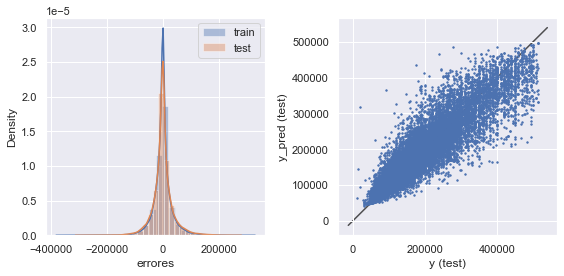

In [81]:
#Evaluación sobre datos reescalados:

aplicar_modelo(regresion_KNN,X_train1, X_test1, y_train1, y_test1)

Tal como podemos ver en el cálculo anterior, de todos los modelos analizados, el que obtuvo un **mejor desempeño** fue el de **Vecinos más cercanos**, fijando en 10 la cantidad de vecinos y aplicando el modelo sobre **datos reescalados**, obteniendo un **RMSE inferior a los USD 37.000** en el grupo de prueba, el valor más bajo de todos los obtenidos hasta el momento.

# B. MODELOS AVANZADOS

En esta parte del trabajo, se incluirán dos **modelos avanzados de Machine Learning:** un modelo de **Regresión Lineal con atributos polinómicos** y un modelo **Random Forest**.

En primer lugar, ambos modelos serán entrenados y evaluados con los argumentos por defecto, y luego se realizará una optimización de sus hiperparámetros aplicando las técnicas de **Grid Search** y **Random Search**, con el objeto de encontrar el modelo que nos dé el **mejor desempeño**, esto es, el valor de RMSE más bajo.

Volvemos a definir los valores de 'X' e 'y' para los datos originales y escalados:

In [31]:
#Seleccionamos las variables predictoras o atributos (X) y la variable a predecir (y) para los DATOS ORIGINALES:

X = properati_ML[['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms','surface_total', 'surface_covered','property_type_Casa',
       'property_type_Departamento', 'property_type_PH', 'Precio_promedio_m2_Barrio']]

y = properati_ML['price']

#Luego seleccionamos el 70% de los datos de X e y como grupo de entrenamiento (train) y el 30% como grupo de prueba (test) del modelo:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [32]:
#Seleccionamos las variables predictoras o atributos (X) y la variable a predecir (y), para los DATOS REESCALADOS:

X1 = properati_escalado[['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms','surface_total', 'surface_covered','property_type_Casa',
       'property_type_Departamento', 'property_type_PH', 'Precio_promedio_m2_Barrio']]

y1 = properati_escalado['price']

#Luego seleccionamos el 70% de los datos de X e y como grupo de entrenamiento (train) y el 30% como grupo de prueba (test) del modelo:
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.30, random_state=42)

## Modelo 1: Regresión Lineal con atributos polinómicos

Raíz del error cuadrado promedio en Train: 49777.80376025147
Raíz del error cuadrado promedio en Test: 49584.6467771613


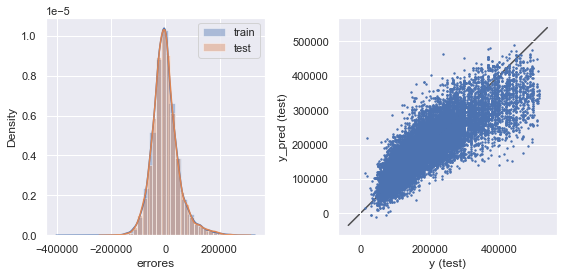

In [84]:
#En primer lugar, entrenamos una regresión lineal simple y evaluamos:
from sklearn.linear_model import LinearRegression

regresion_lineal = LinearRegression()

aplicar_modelo(regresion_lineal,X_train, X_test, y_train, y_test)

Raíz del error cuadrado promedio en Train: 42966.33571441782
Raíz del error cuadrado promedio en Test: 43256.22965660101


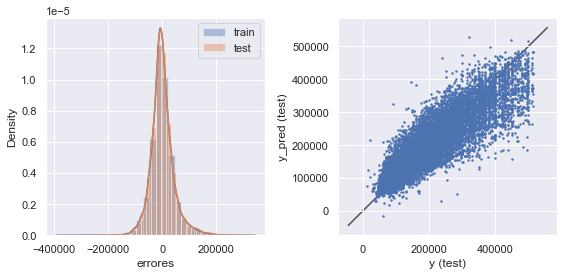

In [46]:
#Luego incorporamos atributos polinómicos a nuestro dataset a través de la clase `PolynomialFeatures`:
from sklearn.preprocessing import PolynomialFeatures

#Creamos un objeto de atributos polinómicos de grado 3:
poly = PolynomialFeatures(degree=3)

#Agregamos los atributos polinómicos al conjunto de datos de entrenamiento y prueba:
X_train_new = poly.fit_transform(X_train)
X_test_new = poly.fit_transform(X_test)

#Por último, evaluamos el modelo aplicando atributos polinómicos:
aplicar_modelo(regresion_lineal,X_train_new, X_test_new, y_train, y_test)

Como se puede observar en lo desarrollado anteriormente, el único valor que se podría considerar como hiperparámetro de este modelo es el grado del polinomio, por lo que realizaremos una optimización manual del mismo comparando los resultados de los polinomios de grado 2 a 5:

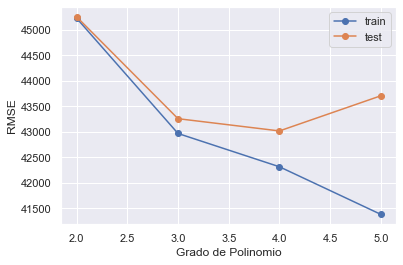

In [60]:
# Definimos las listas vacias para los valores de RMSE deseados:
lista_RMSE_train1 = []
lista_RMSE_test1 = []

# Definimos la lista de valores de k (número de vecinos) que vamos a explorar:
grados_polinomio = [2,3,4,5]

# Generamos en loop sobre los distintos valores de k: 
for g in grados_polinomio:
    
    #Creamos un objeto de atributos polinómicos de grado g:
    poly = PolynomialFeatures(degree=g)

    #Agregamos los atributos polinómicos al conjunto de datos de entrenamiento y prueba:
    X_train_new_ = poly.fit_transform(X_train)
    X_test_new_ = poly.fit_transform(X_test)

    # Definir el modelo:
    regresion_lineal_poli = LinearRegression()
    
    # Entrenar el modelo
    regresion_lineal_poli.fit(X_train_new_,y_train)
    
    # Predecir y evaluar sobre el set de entrenamiento
    y_train_pred2 = regresion_lineal_poli.predict(X_train_new_)
    train_RMSE1 = mean_squared_error(y_train, y_train_pred2, squared = False)
    
    # Predecir y evaluar sobre el set de evaluación
    y_test_pred2 = regresion_lineal_poli.predict(X_test_new_)
    test_RMSE1 = mean_squared_error(y_test, y_test_pred2, squared = False)
    
    # Agregar la información a las listas
    lista_RMSE_train1.append(train_RMSE1)
    lista_RMSE_test1.append(test_RMSE1)

#Luego analizamos el desempeño del modelo para las distintos números de vecinos gráficamente:

sns.set()
plt.plot(grados_polinomio,lista_RMSE_train1,'o-',label='train')
plt.plot(grados_polinomio,lista_RMSE_test1,'o-',label='test')
plt.legend()
plt.xlabel('Grado de Polinomio');
plt.ylabel('RMSE');

Como podemos ver en el gráfico anterior, el grado de polinomio 3 obtiene el mejor desempeño en los grupos de entrenamiento y prueba, sin caer en el sobreajuste de los datos.

Otro método de validación que podemos aplicar sobre el presente modelo es el método de **Validación Cruzada**, esto es, una medida del desempeño del modelo independiente de la separación de datos realizada en los grupos de entrenamiento y prueba.

In [47]:
#Importamos el modelo:
from sklearn.model_selection import cross_validate

#Generamos un modelo de Validación Cruzada en 5 pliegues sobre el grupo de entrenamiento:
from sklearn import metrics
reg_lineal_scores = cross_validate(regresion_lineal, X_train_new, y_train, cv=5,scoring = 'neg_root_mean_squared_error')

#Obtenemos el desempeño o score promedio del modelo utilizando Validación Cruzada:
mean_score = reg_lineal_scores['test_score'].mean() * -1

#Obtenemos el valor de la desviación estándar:
mean_std = reg_lineal_scores['test_score'].std()

#Imprimimos el resultado obtenido
print("El RMSE promedio luego de la VC es: %0.2f (+/- %0.2f)" % (mean_score, mean_std))

El RMSE promedio luego de la VC es: 43628.70 (+/- 434.43)


Esto nos dice que luego de aplicar Validación Cruzada en 5 pliegues sobre el grupo de datos de entrenamiento obtenemos un RMSE promedio de USD 43.628,70 (con una desviación estándar aproximada de USD 435), valor que es un poquito más elevado al que daba el modelo anteriormente, pero que nos da más confianza acerca del desempeño del modelo ante datos nuevos.

Por últimos, aplicaremos el mismo modelo a los datos reescalados:

Raíz del error cuadrado promedio en Train: 49777.80376025153
Raíz del error cuadrado promedio en Test: 49584.646777161244


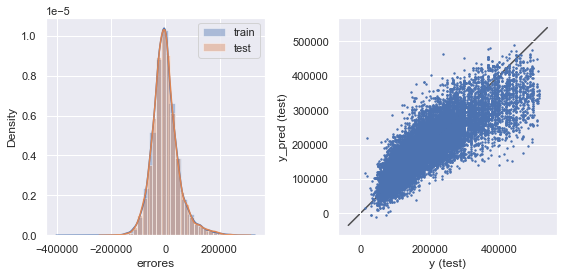

In [48]:
#En primer lugar, entrenamos una regresión lineal simple y evaluamos:
from sklearn.linear_model import LinearRegression

regresion_lineal1 = LinearRegression()

aplicar_modelo(regresion_lineal1,X_train1, X_test1, y_train1, y_test1)

Raíz del error cuadrado promedio en Train: 42864.00997342417
Raíz del error cuadrado promedio en Test: 43152.92398240878


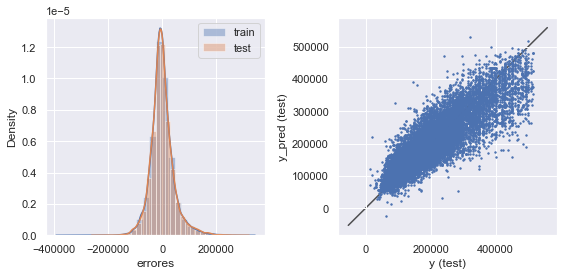

In [49]:
#Luego incorporamos atributos polinómicos a nuestro dataset a través de la clase `PolynomialFeatures`:
from sklearn.preprocessing import PolynomialFeatures

#Creamos un objeto de atributos polinómicos de grado 3:
poly = PolynomialFeatures(degree=3)

#Agregamos los atributos polinómicos al conjunto de datos de entrenamiento y prueba:
X_train1_new = poly.fit_transform(X_train1)
X_test1_new = poly.fit_transform(X_test1)

#Por último, evaluamos el modelo aplicando atributos polinómicos:
aplicar_modelo(regresion_lineal1,X_train1_new, X_test1_new, y_train1, y_test1)

Tal cual se observó en el punto anterior, de todos los modelos de regresión lineal analizados, el que mejor desempeño tuvo sobre el grupo de datos prueba fue el de **Regresión Lineal con atributos polinómicos de grado 3**, aplicado sobre **datos reescalados**, obteniendo un **RMSE menor a USD 43.200**.

En este caso aplicaremos tambíen Validación Cruzada en 5 pliegues:

In [50]:
#Generamos un modelo de Validación Cruzada en 5 pliegues sobre el grupo de entrenamiento:
from sklearn import metrics
reg_lineal1_scores = cross_validate(regresion_lineal1, X_train1_new, y_train1, cv=5,scoring = 'neg_root_mean_squared_error')

#Obtenemos el desempeño o score promedio del modelo utilizando Validación Cruzada:
mean_score = reg_lineal1_scores['test_score'].mean() * -1

#Obtenemos el valor de la desviación estándar:
mean_std = reg_lineal1_scores['test_score'].std()

#Imprimimos el resultado obtenido
print("El RMSE promedio luego de la VC es: %0.2f (+/- %0.2f)" % (mean_score, mean_std))

El RMSE promedio luego de la VC es: 43447.92 (+/- 423.40)


Al igual que pasó en el caso anterior, al aplicar Validación Cruzada sobre el grupo de datos de entrenamiento, se obtuvo un valor de RMSE promedio que supera al que nos daba antes de la validación, pero que nos da más cofianza ante predicciones sobre datos nuevos. A su vez, podemos ver que los valores de error promedio y desviación estándar, son inferiores en el caso del modelo con datos reescalados.

En conslusión, pudimos observar que si bien al incorporar atributos polinómicos al modelo se mejoró sustancialmente el desempeño, este modelo aún no obtiene un mejor desempeño al de vecinos más cercanos analizado en la parte A del trabajo, por lo que a continuación se presenta el otro modelo de esta sección, el modelo **Random Forest**.

## Modelo 2: Random Forest

Este modelo se conoce como **modelo de ensamble**, y consiste en realizar las predicciones a traves del entrenamiento de un conjunto de árboles de decisión.

En nuestro caso, empezaremos el análisis con los valores del algoritmo por defecto, y luego realizaremos una optimización de los mismos aplicando la técnica de **Random Search**.

Raíz del error cuadrado promedio en Train: 12061.844550011308
Raíz del error cuadrado promedio en Test: 28734.758788650306


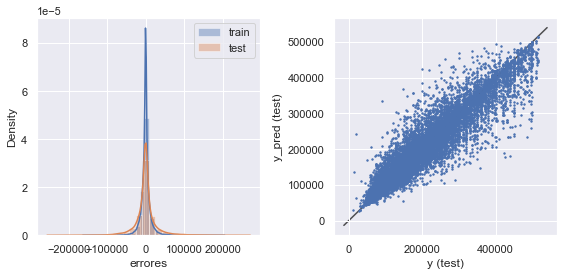

In [36]:
#Importamos el modelo:
from sklearn.ensemble import RandomForestRegressor

#Creamos el modelo considerando los valores por defecto:
random_forest = RandomForestRegressor(n_jobs = -1)

#Luego, entrenamos y evaluamos el modelo a través de la función creada anteriormente:

aplicar_modelo(random_forest,X_train, X_test, y_train, y_test)

Como se puede observar en los valores y gráficos obtenidos, el modelo con los parámetros por defecto nos da un **excelente rendimiento** sobre los datos de entrenamiento, obteniendo un **RMSE aproximado de USD 12.000**, mientras que presenta un **elevado nivel de varianza** al predecir sobre los datos de prueba, elevando el RMSE a casi USD 29.000.

Esta situación no es buena porque el modelo tiende al **overfitting**, por lo que a continuación buscaremos optimizar los hiperparámetros que nos permitan obtener un mejor desempeño del modelo, a través de la técnica conocida como **Random Search**, el cual incluye incorporada el algoritmo de validación cruzada, que realizaremos nuevamente en 5 pliegues.

Los **parámetros** que vamos **a optimizar** son la cantidad de árboles, la profundidad de los mismos, la cantidad de muestras mínimas por nodo y por hoja del árbol, la cantidad de atributos seleccionados para hacer la predicción en cada árbol y la cantidad de muestras de X (variables predictoras) a considerar en cada iteración:

In [57]:
#Definimos los valores de los hiperparámetros que queremos comparar:

parametros = {'n_estimators': list(np.arange(50,325,25)), #cantidad de árboles
              'max_depth': list(np.arange(1,20)),         #profundidad del árbol
              'min_samples_split': list(np.arange(2,10)),
              'min_samples_leaf': list(np.arange(1,5)),
              'max_features':['auto', 'sqrt', 'log2'],
              'max_samples':[None, 100, 1000, 5000, 10000]}

#Importamos el modelo:
from sklearn.model_selection import RandomizedSearchCV

#Creamos el modelo aplicando validación cruzada en 5 pliegues y 250 iteraciones:
random_search = RandomizedSearchCV(random_forest, n_iter=250, param_distributions = parametros, cv=5, scoring='neg_root_mean_squared_error')

# Entrenamos el modelo sobre los datos de entrenamiento:
random_search.fit(X_train, y_train)

#Obtenemos los mejores parámetros y el mejor score o desempeño del modelo:
print("Mejores parametros: "+str(random_search.best_params_))
print("Mejor Score: "+str(random_search.best_score_)+'\n')


Mejores parametros: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': None, 'max_features': 'sqrt', 'max_depth': 17}
Mejor Score: -31430.384689612936



Luego de aplicar el algoritmo de Random Search, obtuvimos los parámetros que nos darían un **RMSE promedio aproximado de USD 31.000** sobre el grupo de datos de entrenamiento (aplicando Validación Cruzada), por lo que a continuación incorporamos dichos parámetros en nuestro modelo original y evualuamos el resultado:

Raíz del error cuadrado promedio en Train: 18784.632721815393
Raíz del error cuadrado promedio en Test: 30210.75695196913


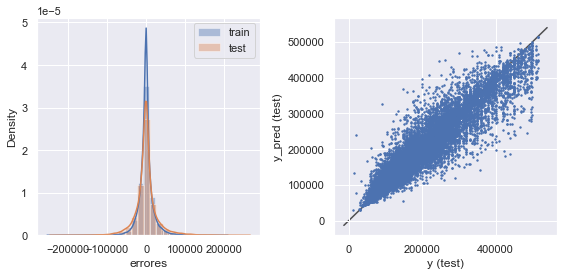

In [86]:
#Volvemos a crear el modelo, esta vez incluyendo los mejores parámetros encontrados en el punto anterior:
random_forest = RandomForestRegressor(n_jobs = -1, n_estimators=75, min_samples_split=3, min_samples_leaf=2, max_samples=None, max_features='auto', max_depth=18)

#Entrenamos y evaluamos una vez más:
aplicar_modelo(random_forest,X_train, X_test, y_train, y_test)

Como podemos ver en el punto anterior, este modelo es el que nos da un **muy buen desempeño** en los grupos de entrenamiento y prueba, obteniendo en este último un **RMSE inferior a USD 30.300**.

Sin embargo, este modelo sigue presentando un **nivel de varianza elevado** entre los datos de entrenamiento y prueba (debido a que existe una gran diferencia entre el RMSE de Train y Test), por lo que estaría sobreajustando también sobre los datos de entrenamiento. Una forma de solucionar este problema es disminuyendo la complejidad del modelo, en nuestro caso, disminuyendo la profundidad de los árboles dentro del Random Forest.

Raíz del error cuadrado promedio en Train: 30475.274832210507
Raíz del error cuadrado promedio en Test: 35084.24498940609


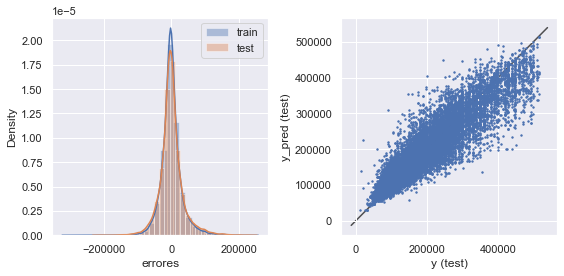

In [37]:
#Volvemos a crear el modelo, esta vez cambiando la profundidad del árbol a 12:
random_forest = RandomForestRegressor(n_jobs = -1, n_estimators=75, min_samples_split=3, min_samples_leaf=2, max_samples=None, max_features='auto', max_depth=12)

#Entrenamos y evaluamos una vez más:
aplicar_modelo(random_forest,X_train, X_test, y_train, y_test)

De acuerdo a los resultados obtenidos, se observó una notable mejora en el desempeño del modelo luego de modificar el parámetro de profundidad de los árboles, ya que **la reducción en la varianza fue superior al incremento del RMSE (error) en el grupo de prueba**, que alcanzó un valor aproximado de **USD 35.000**. En contrapartida, al disminuir la varianza se incrementó un poco el sesgo sobre los datos de entrenamiento (incremento el RMSE), pero esto no sería un problema ya que en definitiva nos interesa un modelo que prediga con el menor error posible sobre datos nunca vistos.

A continuación observamos graficamente la importancia de cada atributo en la predicción:

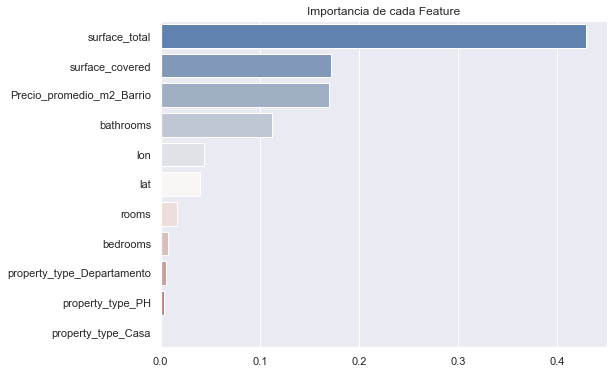

In [88]:
#Analizamos visualmente la importancia de cada atributo en la predicción:

importances = random_forest.feature_importances_
columns = X.columns

#Establecemos el orden en que queremos visualizar el gráfico, creando un diccionario con las columnas y sus respectivos valores:
lista_importances = list(importances)
lista_columnas = list(columns)
dicc = dict(zip(lista_columnas,lista_importances))

#Ordenamos los valores del diccionario
import operator
dicc = sorted(dicc.items(), key=operator.itemgetter(1), reverse = True)

#Establecemos la lista con el orden de importancia de atributos:
orden = []
for columna, valor in dicc:
    orden.append(columna)

plt.figure(figsize=(8,6))
sns.barplot(importances, columns, order = orden, palette='vlag')
plt.xticks(rotation=0)
plt.title('Importancia de cada Feature')
plt.show()

Tal cual se puede observar en el gráfico anterior, la **variable** que sigue siendo **más importante** a la hora de la predicción es la de **superficie total**, seguida de la variable ingresada en reemplazo del Barrio, la superficie cubierta y la cantidad de baños. Esto es de especial importancia, ya que luego de agregar un atributo que no existía originalmente en nuestros datos, pudimos obtener un modelo con mucho mejor desempeño que los anteriores.

Por último, aplicamos el modelo sobre datos reescalados:

Raíz del error cuadrado promedio en Train: 30464.91132338972
Raíz del error cuadrado promedio en Test: 35039.77082287537


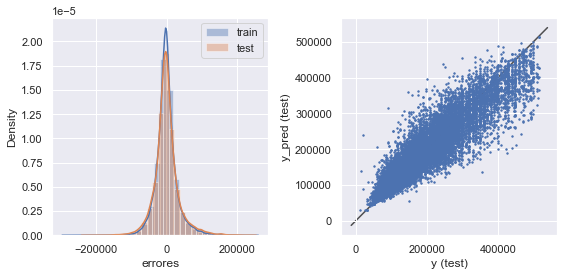

In [89]:
random_forest2 = RandomForestRegressor(n_jobs = -1, n_estimators=75, min_samples_split=3, min_samples_leaf=2, max_samples=None, max_features='auto', max_depth=12)

#Entrenamos y evaluamos una vez más:
aplicar_modelo(random_forest2,X_train1, X_test1, y_train1, y_test1)

Como podemos ver, al aplicar el modelo sobre datos reescalados no existe un cambio sustancial en su desempeño, esto es debido a que el escalado de los datos es indiferente al funcionamiento de los árboles de decisión, ya que van realizando preguntas independientes por variable y separando los datos en nodos en función a dichas preguntas, sin importar si las distintas variables están en diferentes escalas.

# C. INTERPRETACIÓN DE MODELOS:

Antes de comenzar a sacar conclusiones sobre lo trabajado, en primer lugar vamos a resumir los resultados obtenidos sobre los modelos optimizados (considerando todos los atributos como variabes predictoras) en un dataframe y compararlos gráficamente, por un lado para los datos sin escalar y en segundo lugar para los datos reescalados:

In [58]:
#COMPARACIÓN DE RESULTADOS PARA LOS DATOS ORIGINALES:
#Creamos un diccionario con los resultados obtenidos en este proyecto:
resultados2 = {'Modelo':['Regresión lineal', 'Regresión lineal', 'Árbol de decisión', 'Árbol de decisión', 'Vecinos más cercanos', 
                         'Vecinos más cercanos', 'Regresión lineal - Atrib. polin.', 'Regresión lineal - Atrib. polin.',
                        'Random Forest', 'Random Forest'], 
              'Grupo':['Train', 'Test', 'Train', 'Test', 'Train', 'Test', 'Train', 'Test', 'Train', 'Test'], 
              'RMSE':[49777.80376025147, 49584.6467771613, 40256.746315584474, 42090.26923148731, 35375.22431814718, 39618.90096953789,
                     42966.33571441782, 43256.22965660101, 30465.2828680851, 35140.56876873945]}

#Incluimos dichos resultados en un dataframe para mejor visualización:
tabla_resultados2 = pd.DataFrame(resultados2)
tabla_resultados2

,Modelo,Grupo,RMSE
0,Regresión lineal,Train,49777.803760
1,Regresión lineal,Test,49584.646777
2,Árbol de decisión,Train,40256.746316
3,Árbol de decisión,Test,42090.269231
4,Vecinos más cercanos,Train,35375.224318
5,Vecinos más cercanos,Test,39618.900970
6,Regresión lineal - Atrib. polin.,Train,42966.335714
7,Regresión lineal - Atrib. polin.,Test,43256.229657
8,Random Forest,Train,30465.282868
9,Random Forest,Test,35140.568769


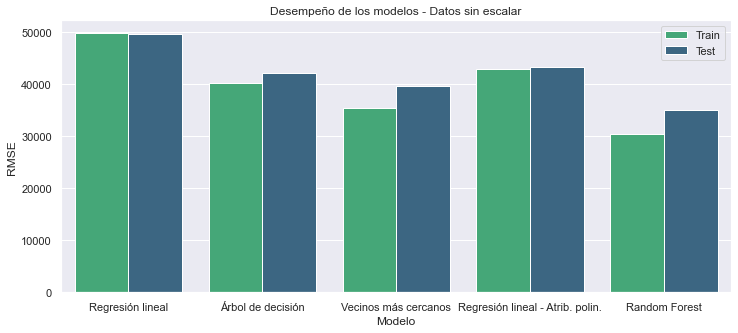

In [59]:
#Observamos los resultados del proyecto (utilizando los datos sin escalar) gráficamente:
plt.figure(figsize=(12,5))
sns.barplot(data = tabla_resultados2, x = 'Modelo', y = 'RMSE', hue = 'Grupo', palette = 'viridis_r')
plt.legend(loc='upper right') 
plt.title('Desempeño de los modelos - Datos sin escalar');

In [60]:
#COMPARACIÓN DE RESULTADOS PARA LOS DATOS ESCALADOS:
#Creamos un diccionario con los resultados obtenidos en este proyecto:
resultados3 = {'Modelo':['Regresión lineal', 'Regresión lineal', 'Árbol de decisión', 'Árbol de decisión', 'Vecinos más cercanos', 
                         'Vecinos más cercanos', 'Regresión lineal - Atrib. polin.', 'Regresión lineal - Atrib. polin.',
                        'Random Forest', 'Random Forest'], 
              'Grupo':['Train', 'Test', 'Train', 'Test', 'Train', 'Test', 'Train', 'Test', 'Train', 'Test'], 
              'RMSE':[49777.80376025153, 49584.646777161244, 40256.603605559416, 42105.37752663443, 32915.64240082015, 36871.406380383465,
                     42864.00997342417, 43152.92398240878, 30373.093076647827, 35033.09063077032]}

#Incluimos dichos resultados en un dataframe para mejor visualización:
tabla_resultados3 = pd.DataFrame(resultados3)
tabla_resultados3

,Modelo,Grupo,RMSE
0,Regresión lineal,Train,49777.803760
1,Regresión lineal,Test,49584.646777
2,Árbol de decisión,Train,40256.603606
3,Árbol de decisión,Test,42105.377527
4,Vecinos más cercanos,Train,32915.642401
5,Vecinos más cercanos,Test,36871.406380
6,Regresión lineal - Atrib. polin.,Train,42864.009973
7,Regresión lineal - Atrib. polin.,Test,43152.923982
8,Random Forest,Train,30373.093077
9,Random Forest,Test,35033.090631


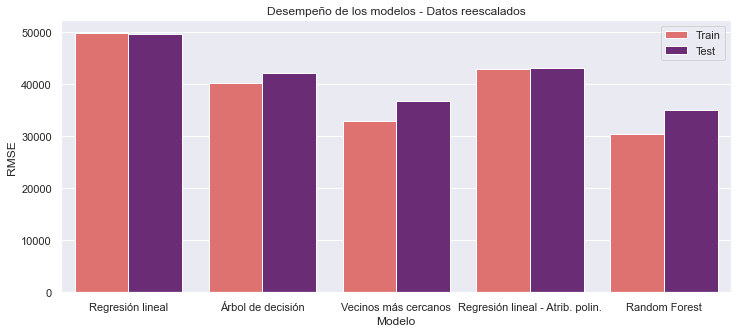

In [61]:
#Observamos los resultados del proyecto (utilizando los datos reescalados) gráficamente:
plt.figure(figsize=(12,5))
sns.barplot(data = tabla_resultados3, x = 'Modelo', y = 'RMSE', hue = 'Grupo', palette = 'magma_r')
plt.legend(loc='upper right') 
plt.title('Desempeño de los modelos - Datos reescalados');

De acuerdo a todo lo expuesto, el modelo que tuvo **mejor desempeño** fue el **Random Forest** visto en el punto anterior, que redujo el RMSE a un valor aproximado de **USD 35.000**. Sin embargo, este valor nos indica que el modelo sigue presentando un **sesgo** al efectuar la predicción, por lo que en este punto del trabajo, trataremos de encontrar el origen del mismo.

En primer lugar, analizaremos la distribución de los errores, para ver en dónde esta fallando nuestro modelo:

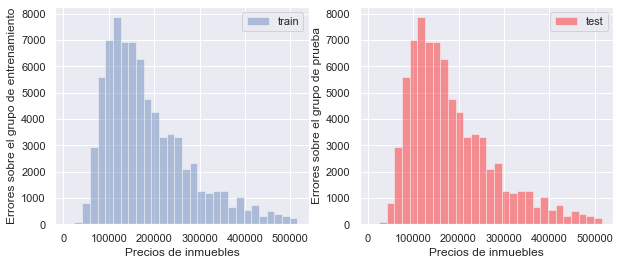

In [56]:
#En primer lugar, entrenamos el modelo con los datos de entrenamiento
random_forest.fit(X_train, y_train)

#Predecimos la los valores de la variable 'y' sobre los grupos de entrenamiento y prueba:
y_train_pred = random_forest.predict(X_train)
y_test_pred = random_forest.predict(X_test)

#Luego calculamos los errores en cada grupo:
errores_train = y_train_pred - y_train
errores_test = y_test_pred - y_test

#Visualizamos la distribución de errores en funcion al precio de los inmuebles:
sns.set()
plt.figure(figsize = (10,4))

#Errores Train:
plt.subplot(1,2,1)
sns.distplot(errores_train, bins = 30, label = 'train', x = properati_ML['price'], kde = False)
plt.xlabel('Precios de inmuebles')
plt.ylabel('Errores sobre el grupo de entrenamiento')
plt.legend();

#Errores Test:
plt.subplot(1,2,2)
sns.distplot(errores_test, bins = 30, label = 'test', x = properati_ML['price'], kde = False, color = 'red')
plt.xlabel('Precios de inmuebles')
plt.ylabel('Errores sobre el grupo de prueba')
plt.legend();

Como podemos ver en los gráficos anteriores, el modelo estaría concentrando la **mayor cantidad de errores** en las **propiedades** que se encuentran en un precio **entre USD 100.000 y 200.000**.

Si comparamos el desempeño de todos los modelos con los de la primer entrega, que consideraban como variables predictoras a la **superficie total y cubierta**, observamos que hubo una mejora general en los mismos, la cual se debió principalmente a las técnicas de pre-procesamiento aplicadas sobre los datos (ya que pudimos contar con mayor información para que el modelo aprenda), y a incorporar nuevos atributos como variables predictoras del precio del inmueble. 

Al incorporar las otras variables al dataset, el desempeño de todos los modelos mejoró de acuerdo a lo esperado, pero no todas las variables tuvieron el mismo peso. Tal cual se analizó en el punto anterior, las variables que fueron más importantes para el modelo elegido al momento de efectuar la predicción fueron la **superficie total**, el **barrio**, la **superficie cubierta** y la **cantidad de baños**. Sin embargo, cuando analizabamos los valores faltantes de nuestro set de datos vimos que las variables de superficie y baños contenían información faltante, que fueron reemplazadas por valores estadísticos calculados en función al tipo de propiedad sobre un nuevo set de datos depurado de outliers o valores atípicos. Esta técnica, si bien es sencilla de aplicar a la hora de imputación de los valores faltantes, puede generar error, ya que los valores de superficie y cantidad de baños no necesariamente son iguales en cada tipo de propiedad, sino que pueden variar también por otros factores independientes del tipo de propiedad de la que se trate, como por ejemplo el barrio donde se encuentre el inmueble.

Por otro lado, un descubrimiento importante del trabajo fue la mejora en el desempeño del modelo al incorporar la variable **'Precio_promedio_m2_Barrio'** a través de una técnica de encoding de la variable categórica **Barrio**, ya que como se mencionó anteriormente, quedó en segundo lugar en importancia. Sin embargo, los valores promedio por barrio fueron calculados sobre la variable de superficie total (que contenia valores faltantes imputados), sobre un set de datos depurado de valores elevados o atípicos, por lo cual dichos promedios pueden ser distintos a los valores reales (en algunos casos, inferiores), y por ende no estarían reflejando la diferencia de precios real que puede existir en distintos barrios, provocando también un sesgo en la predicción.

De acuerdo a todo lo expuesto anteriormente y considerando la importancia de la variable **superficie total** a la hora de realizar la predicción, a continuación analizaremos la distribución de valores faltantes para dicha variable en función al precio de las propiedades, con el objetivo de encontrar si existe alguna relación con la distribución de los errores del modelo:

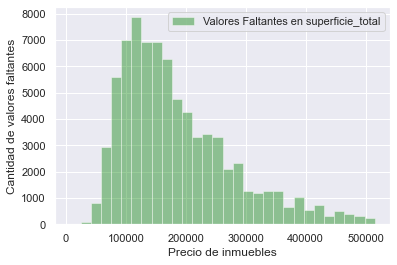

In [57]:
#Importamos nuevamente el dataset con datos faltantes y eliminamos filas duplicadas:
data = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv')
data = data.drop_duplicates()

#Luego buscaremos la cantidad de valores faltantes por intervalos de precio:
data['intervalos_precio'] = pd.cut(data['price'], bins  = 10)
vf_sup_price = data['surface_total'].isnull().groupby([data['intervalos_precio']]).sum().astype(int).reset_index(name='count')

#Analizamos gráficamente la distribución de valores faltantes de la variable Superficie Total por precio de inmuebles:
sns.distplot(vf_sup_price, bins = 30, label = 'Valores Faltantes en superficie_total', x = properati_ML['price'], kde = False, color = 'green')
plt.ylabel('Cantidad de valores faltantes')
plt.xlabel('Precio de inmuebles')
plt.legend();

Tal cual vemos en el gráfico anterior, los **valores faltantes** en la variable **Superficie Total** tienen casi la **misma distribución que los errores del modelo**, concentrándose entre **propiedades** que se encuentran **entre los USD 100.000 y 200.000**. Esto nos demuestra que **gran parte del sesgo de nuestro modelo** podría estar **originándose** en el **método de imputación de valores faltantes** utilizado.

Por otro lado, en cuanto a la aplicación del modelo utilizando datos escalados o no, considero que para el modelo elegido es indiferente, ya que la manera de operar de los árboles de decisión que componen el Random Forest es independiente de la escala que se utilicen. Sin embargo, cabe destacar que en el modelo de **Vecinos más cercanos** fue donde se vió una **mejora considerable** al incluir los **datos reescalados**, obteniendo un **RMSE inferior a los USD 37.000** y posicionado al modelo en **segundo lugar** en términos del RMSE obtenido.

En conclusión, creo que el **sesgo** que presentan los modelos del presente trabajo está **originado** principalmente por la metodología aplicada para la **imputación de valores faltantes** de las dos **variables de superficie** (las más importantes a la hora de efectuar la predicción) y también podría ser porque los datos con los que contamos no comtemplan la antigüedad del inmueble, que es otra variable que podría estar directamente relacionado con el precio del mismo.

# DESAFÍO OPCIONAL - CLUSTERING

En este punto del trabajo se incorporarán tecnicas de Clustering (o agrupamiento) con el objeto de incorporar al modelo elegido (Random Forest) etiquetas que representen las diferentes zonas geográficas que más se parecen entre sí, y luego evaluar su desempeño.

Para ello, en primer lugar se buscará la cantidad óptima de clusters a traves de dos técnicas: el **método Elbow (o del codo)** y el **Silhouette score**. Una vez obtenidas la cantidad de clusters óptima, se incorporaran a nuestro dataset las etiquetas mencionadas anteriormente a través de la técnica de clusterización conocida como **K-means**, que se aplicará sobre las variables de latitud, longitud y precio promedio por metro cuadrado (por barrio) únicamente.

Por último, se entrenará y evaluará un modelo Random Forest (utilizando los mejores hiperparámetros encontrados anteriormente) y se analizarán los resultados.

Para llevar a cabo todo esto, realizaremos una copia del dataset y reescalaremos las variables de interés.

In [176]:
#En primer lugar, creamos una copia del dataset:

properati_clusters = properati_ML.copy()

#Seleccionamos las variables que vamos a reescalar:

col_escal = properati_clusters[['lat', 'lon','Precio_promedio_m2_Barrio']]

#Importamos el escalador:
from sklearn.preprocessing import StandardScaler

escalador = StandardScaler()

#Reeplazamos por los valores escalados en el nuevo dataset:

properati_clusters[['lat', 'lon','Precio_promedio_m2_Barrio']] = escalador.fit_transform(col_escal)

#Seleccionamos las variables sobre las que aplicaremos K-meas:

X_clusters = properati_clusters[['lat', 'lon','Precio_promedio_m2_Barrio']]

## Cantidad óptima de clusters:

## 1. Método Elbow

In [177]:
#Importamos el modelo clusterización:
from sklearn.cluster import KMeans

# Preparamos una lista donde vamos a ir agregando las distancias medias
lista_distancias_medias = []

# Entrenamos un modelo para cada numero de cluster que queremos testear:
K = np.arange(2,11)
for k in K:
    # Definimos y entrenamos el modelo
    km = KMeans(n_clusters=k)
    km = km.fit(X_clusters)
    # Tomamos la suma de las distancias para todas las instancias del dataset
    distancia_total = km.inertia_
    # Calculamos la distancia media y agregamos a la lista
    distancia_media = np.divide(distancia_total,X_clusters.shape[0])
    lista_distancias_medias.append(distancia_media)

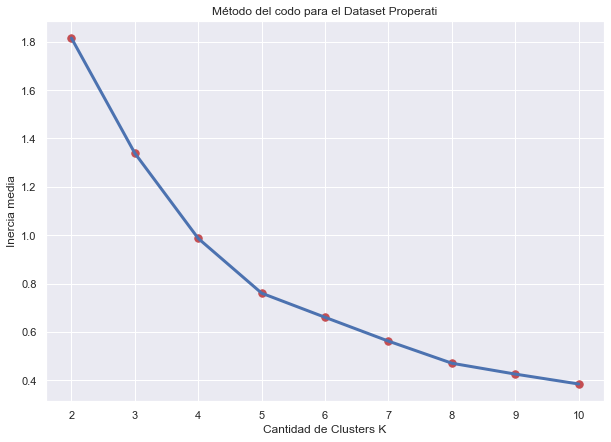

In [178]:
#Graficamos la distancia media en funcion al numero de clusters:
plt.figure(figsize = (10,7))

# Graficamos una linea continua y tambien unos puntos para resaltar los valores enteros de K.
plt.plot(K, lista_distancias_medias, lw=3)
plt.scatter(K, lista_distancias_medias,s=55,c='r')
plt.xlabel('Cantidad de Clusters K')
plt.ylabel('Inercia media')
plt.title('Método del codo para el Dataset Properati')

plt.show()

De acuerdo a lo observado en el gráfico anterior, la cantidad óptima de clusters para nuestro dataset sería de 5. A continuación se comparará este valor con el que nos da la técnica de Silhouette.

## 2. Silhouette

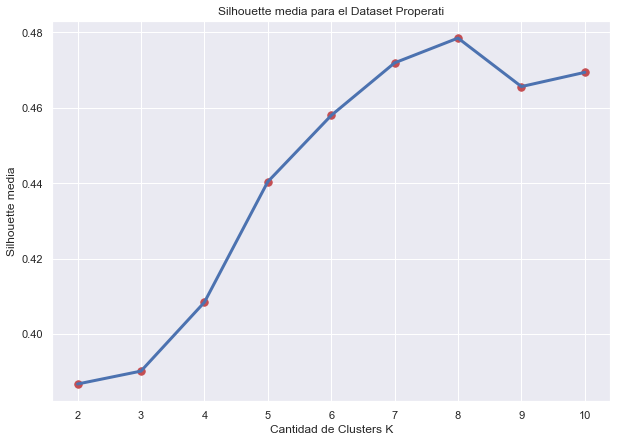

In [179]:
#Importamos la métrica:
from sklearn.metrics import silhouette_samples, silhouette_score

# Preparamos una lista donde vamos a ir agregando los valores medios de silhouette
lista_sil = []
# Fiteammos un modelo para cada numero de cluster que queremos testear
for k in range(2,11):
    # Definimos y entrenamos el modelo
    km = KMeans(n_clusters=k)
    km = km.fit(X_clusters)
    
    # Tomamos las etiquetas
    etiquetas = km.labels_
    
    # Calculamos el silhouette 
    valor_medio_sil = silhouette_score(X_clusters, etiquetas)
    lista_sil.append(valor_medio_sil)
    
plt.figure(figsize = (10,7))
plt.plot(K, lista_sil, lw=3)
plt.scatter(K, lista_sil,s=55,c='r')
plt.xlabel('Cantidad de Clusters K')
plt.ylabel('Silhouette media')
plt.title('Silhouette media para el Dataset Properati')

plt.show()

Como podemos ver en el gráfico anterior, este método nos dice que la cantidad óptima de clusters debería ser de 8, por lo que a continuación aplicaremos la técnica de clusterización conocida como K-means utilizando dicho número ya que tiene en consideración la separación entre clusters:

# Aplicando K-means sobre nuestro dataset:

In [180]:
#Importamos en instanciamos el modelo, considerando la cantidad de clusters elegida:
from sklearn.cluster import KMeans

kmeans_properati = KMeans(n_clusters=8)

#Entenamos el modelo sobre las variables elegidas:
kmeans_properati.fit(X_clusters)

#Incorporamos las etiquetas a nuestro dataset original:
properati_ML['cluster'] = kmeans_properati.labels_

properati_ML.head()

,Barrio,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type_Casa,property_type_Departamento,property_type_PH,Precio por m2,Precio_promedio_m2_Barrio,cluster
1,Boedo,-34.624056,-58.412110,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,1,2271.428571,2053.631346,2
2,Palermo,-34.593569,-58.427474,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,1,2777.777778,3210.083120,3
3,Palermo,-34.581294,-58.436754,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,1,3470.588235,3210.083120,3
5,Villa Crespo,-34.593779,-58.441239,2.0,1.0,1.0,56.0,56.0,150000.0,0,0,1,2678.571429,2467.393712,5
6,Villa Crespo,-34.600988,-58.433061,2.0,1.0,1.0,70.0,70.0,159500.0,0,0,1,2278.571429,2467.393712,5


In [181]:
#Seleccionamos las variables predictoras o atributos (X) para nuestro modelo:

X2 = properati_ML[['lat', 'lon','rooms', 'bedrooms', 'bathrooms','surface_total', 'surface_covered','property_type_Casa',
       'property_type_Departamento', 'property_type_PH', 'Precio_promedio_m2_Barrio', 'cluster']]

#Definimos la variable a predecir utilizando los datos originales:
y2 = properati_ML['price']

#Luego seleccionamos el 70% de los datos de X e y como grupo de entrenamiento (train) y el 30% como grupo de prueba (test) del modelo:
from sklearn.model_selection import train_test_split

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.30, random_state=42)

Raíz del error cuadrado promedio en Train: 30472.81080532999
Raíz del error cuadrado promedio en Test: 35059.73704281706


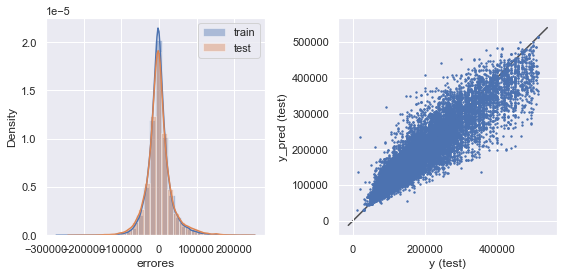

In [183]:
#Volvemos a crear el modelo utilizados los mejores hiperparámetros obtenidos anteriormente:

random_forest = RandomForestRegressor(n_jobs = -1, n_estimators=75, min_samples_split=3, min_samples_leaf=2, max_samples=None, max_features='auto', max_depth=12)

#Entrenamos y evaluamos una vez más:
aplicar_modelo(random_forest,X_train2, X_test2, y_train2, y_test2)

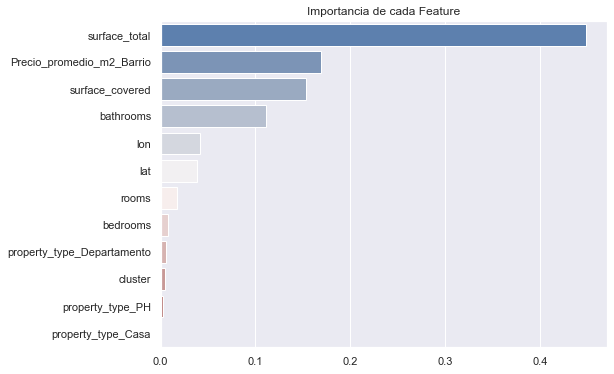

In [184]:
#Analizamos visualmente la importancia de cada atributo en la predicción:

importances = random_forest.feature_importances_
columns = X2.columns

#Establecemos el orden en que queremos visualizar el gráfico, creando un diccionario con las columnas y sus respectivos valores:
lista_importances = list(importances)
lista_columnas = list(columns)
dicc = dict(zip(lista_columnas,lista_importances))

#Ordenamos los valores del diccionario
import operator
dicc = sorted(dicc.items(), key=operator.itemgetter(1), reverse = True)

#Establecemos la lista con el orden de importancia de atributos:
orden = []
for columna, valor in dicc:
    orden.append(columna)

plt.figure(figsize=(8,6))
sns.barplot(importances, columns, order = orden, palette='vlag')
plt.xticks(rotation=0)
plt.title('Importancia de cada Feature')
plt.show()

Como podemos ver en los resultados expuestos, la incorporación de las etiquetas obtenidas por la técnica de clusterización aplicada **no generó un cambio sustancial en el desempeño del modelo**, ya que se obtuvieron prácticamente los mismos resultados que el modelo anterior.